# Compare anchor probability before/after peak in Twitter
Let's compare the use of anchors before and after peak collective attention in the Twitter data. We define a "peak time" for (1) each dataset based on time of peak post frequency and (2) each NE based on time of peak frequency.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import dateutil
# load full data
full_data = pd.read_csv('../../data/mined_tweets/combined_tweet_tag_data.gz', sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})
# load anchor data
anchor_data = pd.read_csv('../../data/mined_tweets/combined_tweet_tag_data_NE_flat_parsed_anchor.gz', sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})

In [3]:
x = anchor_data.loc[:, 'NE_fixed'].value_counts()
print(len([y for y in x.index if ' ' in y]))

1804


In [5]:
# fix bad usernames
anchor_data = anchor_data.assign(**{'username' : anchor_data.loc[:, 'username'].apply(lambda x: x.split(':')[-1])})

Let's check to see that the anchors actually make sense.

In [6]:
for name_i, data_i in anchor_data.groupby('data_name_fixed'):
    print('testing data %s'%(name_i))
    display(data_i[data_i.loc[:, 'anchor']==1].drop_duplicates(['NE_fixed', 'data_name_fixed'], inplace=False).loc[:, ['NE_fixed', 'txt']].head(10).values)

testing data florence


array([['wilmington',
        'RT @MelissaNordWx: New 11 AM Advisory from the National hurricane center has #Florence making a landfall near Wilmington, NC as a major hur…'],
       ['charleston',
        'Shoutout to #HurricaneFlorence for ruining my Charleston vacation.... looks like I’m sticking around in TN this wee… <URL>'],
       ['north',
        'UAE citizens in Virginia, North and South Carolina areas, #HurricaneFlorence may become a category 4 storm. Stay tu… <URL>'],
       ['wilson',
        'Walmart is already of water in Wilson , NC. Stay safe everyone! #Florence <URL>'],
       ['pender county',
        'RT @wectnews: Pender County schools will now be closed from Tuesday to Friday due to #HurricaneFlorence.   The latest closings » <URL>'],
       ['byron',
        'RT @abparrish083: Adorable Pet Salon &amp; Spa in Byron, GA Attention: To all Hurricane #Florence Evacuees we are offering $5.00 boarding for p…'],
       ['new bern',
        'RT @EdValleeWx: Our models spec

testing data harvey


array([['galveston',
        'Today looks like a great day to cool off at the beach in Galveston, TX. This weekend could get dicey. #txwx #Harvey <URL>'],
       ['brownsville',
        'The 12km 18Z RPM intensifies #Harvey up to a Category 1 Hurricane prior to a Brownsville landfall on Friday. One of many more runs to come. <URL>'],
       ['victoria',
        "@KevinRothWx I'm traveling to Houston from Victoria,TX Sat. for a live football draft. What color code do you give the weather? #Harvey"],
       ['corpus christi',
        'Pretty calm down at the coast today. #Harvey JP Luby Beach, Corpus Christi, TX 8pm 8/22/17 <URL>'],
       ['houston',
        "Tropical Storm Harvey. I might need to start paying attention to this storm. Looks like it's going to hit Houston, Texas. #Harvey"],
       ['padre island',
        "Good - let's not have kittens on Padre Island / Corpus Christi until the new center is found and models are updated. #Harvey <URL>"],
       ['lake charles',
        '

testing data irma


array([['south beach', "South Beach, like Florida? Don't do that. #Irma"],
       ['houston',
        'This hurricane business is serious. Praying for my good friends, as well as colleagues in Houston, TX as they prepare for #HurricaneHarvey'],
       ['rockport',
        'More confirmation of major structural damage to buildings in Rockport, TX after experiencing the western eyewall. #Harvey <URL>'],
       ['charleston',
        ". @NHC_Atlantic watching what's south of Charleston, SC. #Irma could develop tonight or Monday. Rough surf for coastal GA, no threat here. <URL>"],
       ['jacksonville',
        'NC friends: A tropical storm ( #Irma ) is developing just east of Jacksonville, Florida tonight. It will move up... <URL>'],
       ['davie',
        '@Costco 1/2 Thank you to Paul from Store #91 in Davie, FL! News broke today that #Irma is going 2 be a major hurricane & heading our way.'],
       ['glynn county',
        'I am just north of you, in Glynn County GA. I got my flash

testing data maria


array([['san juan',
        'Cheap #flights to San Juan, Puerto Rico - Compare these prices & Save! <URL>'],
       ['arecibo',
        '"Anybody Out There?" Arecibo Observatory, Arecibo, Puerto Rico Photo Credi... #photographingGOD #photography #puertorico #areciboobservatory <URL>'],
       ['carolina',
        'Looking for English Teacher (Elementary Level) in Carolina, Puerto Rico Please PM me #englishteacher #PuertoRico #teacherlife'],
       ['salinas',
        '#sunset in #salinas #puertorico atardecer en Salinas, Puerto Rico #aroundtheworld … <URL>'],
       ['union',
        'Current situation in #HatoRey during the union protests against the fiscal oversight board <URL>'],
       ['island of vieques',
        'Day Trip to the Island of Vieques, Puerto Rico <URL>'],
       ['parguera',
        'La Parguera "identidad" #puertorico #ponce #pastayqueso #parguerapr #banderas en La Parguera… <URL>'],
       ['santurce',
        'Ready para el festival del uso de la palabra "peligro

testing data michael


array([['orlando',
        '@carolinemenzies @iCyclone I live here in the Orlando,FL area. We will prepare if it comes our way! #HurricaneMichael'],
       ['panhandle',
        "RT @DrShepherd2013: I am worried about #Michael ...trending towards stronger storm at landfall and that area of Panhandle of Florida hasn't…"],
       ['pee dee',
        '#Michael forecast to come through South Carolina as a tropical storm on Thursday, drenching the Pee Dee and southeastern North Carolina - areas still drying out from #FlorenceLatest word ➡️ <URL>'],
       ['miami beach',
        'Distant #feederbands from Hurricane #Michael rolling through Biscayne Bay this morning, 5 miles NW of Miami Beach, FL. @JohnMoralesNBC6 @spann <URL>'],
       ['pensacola beach',
        'RT @NWSMobile: 🚩🌊Red flags are now flying at Pensacola Beach, FL in advance of Hurricane #Michael. This means the Gulf is CLOSED to swimmin…'],
       ['apalachicola',
        'Shrimp boats heading to the creeks up the Apalachicol

### Fix time zones

We have to fix the time zones because some tweets don't have them, which means that the times are off by X hours unless corrected.

In [7]:
from datetime import datetime
def fix_timezone(x, date_fmt='%Y-%m-%d %H:%M:%S', timezone_str='+0000'):
    # add timezone offset for "naive" dates
    if(x.utcoffset() is None):
        x = datetime.strptime('%s%s'%(x.strftime(date_fmt), timezone_str), '%s%%z'%(date_fmt))
    return x
date_var = 'date'
full_data = full_data.assign(**{time_var : full_data.loc[:, time_var].apply(lambda x: fix_timezone(x))})
anchor_data = anchor_data.assign(**{time_var : anchor_data.loc[:, time_var].apply(lambda x: fix_timezone(x))})

In [9]:
# test min date comparison
assert anchor_data.loc[:, date_var].min() is not None
assert anchor_data.loc[:, date_var].max() is not None

In [10]:
## add time var
from datetime import datetime
def round_to_day(x):
    x_day = datetime(day=x.day, month=x.month, year=x.year)
    return x_day
time_var = 'date'
round_time_var = '%s_day'%(time_var)
full_data = full_data.assign(**{round_time_var : full_data.loc[:, time_var].apply(lambda x: round_to_day(x))})
anchor_data = anchor_data.assign(**{round_time_var : anchor_data.loc[:, time_var].apply(lambda x: round_to_day(x))})

## Compute peak frequency time
Let's use day as the unit of analysis because it's easier to deal with, even if it leads to data sparsity.

Compute peak time for (1) data set.

In [11]:
def compute_peak_time(data, time_var='date_day', data_name_var='data_name_fixed', verbose=True):
    """
    Compute peak frequency time for data.
    """
    data_freq = data.groupby(time_var).apply(lambda x: x.shape[0])
    if(verbose):
        print('data %s'%(data.loc[:, data_name_var].iloc[0]))
        print(data_freq)
    peak_time = data_freq.sort_values(inplace=False, ascending=False).index[0]
    return peak_time
data_name_var = 'data_name_fixed'
data_peak_times = full_data.groupby(data_name_var).apply(lambda x: compute_peak_time(x, time_var=round_time_var, data_name_var=data_name_var))

data florence
date_day
2018-08-29        2
2018-08-30       10
2018-08-31        5
2018-09-01       36
2018-09-02       17
2018-09-03       20
2018-09-04       40
2018-09-05      112
2018-09-06      100
2018-09-07      163
2018-09-08      254
2018-09-09      401
2018-09-10     1379
2018-09-11     1989
2018-09-12     3379
2018-09-13     5487
2018-09-14     6462
2018-09-15     4476
2018-09-16     2759
2018-09-17    12622
2018-09-18    12943
2018-09-19    10468
2018-09-20     7177
2018-09-21     5184
2018-09-22     2778
2018-09-23     2396
2018-09-24     3188
2018-09-25     2322
2018-09-26      136
dtype: int64
data florence
date_day
2018-08-29        2
2018-08-30       10
2018-08-31        5
2018-09-01       36
2018-09-02       17
2018-09-03       20
2018-09-04       40
2018-09-05      112
2018-09-06      100
2018-09-07      163
2018-09-08      254
2018-09-09      401
2018-09-10     1379
2018-09-11     1989
2018-09-12     3379
2018-09-13     5487
2018-09-14     6462
2018-09-15     4476
2

In [12]:
display(data_peak_times)

data_name_fixed
florence   2018-09-18
harvey     2017-08-25
irma       2017-09-09
maria      2017-09-30
michael    2018-10-12
dtype: datetime64[ns]

Add peak dates to anchor data.

In [15]:
anchor_data = anchor_data.assign(**{'data_peak_date' : anchor_data.loc[:, 'data_name_fixed'].apply(lambda x: data_peak_times.loc[x])})

Compute peak frequency time for (2) consistent NEs.

In [16]:
data_name_var = 'data_name_fixed'
NE_var = 'NE_fixed'
min_NE_count = 20
anchor_data_NE_peak = []
for name_i, data_i in anchor_data.groupby(data_name_var):
#     print('data=%s'%(name_i))
    NE_counts = data_i.loc[:, NE_var].value_counts()
#     display(NE_counts)
    NE_consistent = NE_counts[NE_counts >= min_NE_count].index.tolist()
    data_i_NE = data_i[data_i.loc[:, NE_var].isin(NE_consistent)]
    data_i_NE_peak_times = data_i_NE.groupby(NE_var).apply(lambda x: compute_peak_time(x, time_var=round_time_var, verbose=False))
    display(data_i_NE_peak_times)
    data_i_NE_peak_times = pd.DataFrame(data_i_NE_peak_times).rename(columns={0:'NE_peak_date'})
    data_i_NE_peak_times = data_i_NE_peak_times.assign(**{'NE_fixed' : data_i_NE_peak_times.index})
    data_i_NE_peak_times.index = np.arange(data_i_NE_peak_times.shape[0])
    display(data_i_NE_peak_times.head())
    data_i = pd.merge(data_i, data_i_NE_peak_times, on='NE_fixed', how='inner')
    anchor_data_NE_peak.append(data_i)
anchor_data_NE_peak = pd.concat(anchor_data_NE_peak, axis=0)
print('%d/%d data retained'%(anchor_data_NE_peak.shape[0], anchor_data.shape[0]))

NE_fixed
alert                 2018-09-20
asheville             2018-09-16
atlanta               2018-09-13
atlantic beach        2018-09-13
beaufort              2018-09-14
bermuda               2018-09-20
bladen county         2018-09-17
brunswick             2018-09-17
brunswick county      2018-09-19
burgaw                2018-09-18
cape fear             2018-09-13
carolina              2018-09-18
carolina beach        2018-09-17
cary                  2018-09-14
center                2018-09-18
chapel hill           2018-09-17
charleston            2018-09-13
charlotte             2018-09-14
chesterfield          2018-09-17
chesterfield county   2018-09-17
columbus              2018-09-17
columbus county       2018-09-20
conway                2018-09-19
cumberland            2018-09-17
cumberland county     2018-09-19
duplin county         2018-09-20
durham                2018-09-17
elizabethtown         2018-09-18
emerald isle          2018-09-16
fayetteville          2018-09-17
 

,NE_peak_date,NE_fixed
0,2018-09-20,alert
1,2018-09-16,asheville
2,2018-09-13,atlanta
3,2018-09-13,atlantic beach
4,2018-09-14,beaufort


NE_fixed
abbott              2017-08-28
abilene             2017-08-28
addicks             2017-08-29
africa              2017-08-28
alexandria          2017-08-31
aransas county      2017-08-26
aransas pass        2017-08-25
arlington           2017-08-28
asia                2017-08-30
atlanta             2017-08-28
austin              2017-08-25
bastrop             2017-08-27
bastrop county      2017-08-27
baton rouge         2017-08-28
bay                 2017-08-25
bay city            2017-08-28
baytown             2017-08-29
bear creek          2017-08-30
beaumont            2017-08-30
bell county         2017-08-25
bellaire            2017-08-27
bexar county        2017-08-26
biloxi              2017-08-24
bolivar peninsula   2017-08-26
boston              2017-08-29
brazoria            2017-08-25
brazoria county     2017-08-29
brazos              2017-08-28
bridge city         2017-08-30
brownsville         2017-08-25
                       ...    
sienna plantation   2017-08-26

,NE_peak_date,NE_fixed
0,2017-08-28,abbott
1,2017-08-28,abilene
2,2017-08-29,addicks
3,2017-08-28,africa
4,2017-08-31,alexandria


NE_fixed
aiken               2017-09-11
alachua             2017-09-08
alachua county      2017-09-10
alert               2017-09-10
altamonte springs   2017-09-12
amelia island       2017-09-11
anguilla            2017-09-06
anna maria island   2017-09-07
apollo beach        2017-09-10
apopka              2017-09-11
arlington           2017-09-11
athens              2017-09-11
atlanta             2017-09-11
atlantic beach      2017-09-11
auburn              2017-09-09
augusta             2017-09-11
bay                 2017-09-10
bay county          2017-09-10
bayshore            2017-09-10
beach               2017-09-10
beaufort            2017-09-08
beaufort county     2017-09-11
belle glade         2017-09-13
berkeley            2017-09-08
berkeley county     2017-09-08
bermuda             2017-09-06
birmingham          2017-09-11
black creek         2017-09-11
bluffton            2017-09-11
boca raton          2017-09-10
                       ...    
sunny isles beach   2017-09-09

,NE_peak_date,NE_fixed
0,2017-09-11,aiken
1,2017-09-08,alachua
2,2017-09-10,alachua county
3,2017-09-10,alert
4,2017-09-12,altamonte springs


NE_fixed
adjuntas       2017-09-27
aguadilla      2017-09-21
arecibo        2017-09-20
bayamon        2017-09-20
cabo rojo      2017-09-21
caguas         2017-09-21
cana           2017-09-20
canovanas      2017-09-21
carolina       2017-09-26
cayey          2017-09-21
culebra        2017-09-18
fajardo        2017-09-20
guayama        2017-09-20
guayanilla     2017-09-28
guaynabo       2017-10-03
humacao        2017-09-21
isla verde     2017-09-20
jayuya         2017-09-21
lajas          2017-10-01
las vegas      2017-10-03
loiza          2017-09-21
los angeles    2017-10-01
manati         2017-10-06
maunabo        2017-09-20
mayaguez       2017-09-29
nola           2017-09-25
ponce          2017-09-21
quebradillas   2017-09-22
rio grande     2017-09-20
salinas        2017-09-21
san juan       2017-09-30
santiago       2017-09-21
santurce       2017-09-22
toa baja       2017-09-22
union          2017-09-30
utuado         2017-09-21
vegas          2017-10-02
vieques        2017-10-01
yab

,NE_peak_date,NE_fixed
0,2017-09-27,adjuntas
1,2017-09-21,aguadilla
2,2017-09-20,arecibo
3,2017-09-20,bayamon
4,2017-09-21,cabo rojo


NE_fixed
apalachicola        2018-10-12
atlanta             2018-10-10
atlantic            2018-10-11
bainbridge          2018-10-17
bay                 2018-10-16
bay county          2018-10-12
beach               2018-10-12
blountstown         2018-10-13
calhoun             2018-10-18
calhoun county      2018-10-15
center              2018-10-18
clearwater          2018-10-13
danville            2018-10-12
decatur county      2018-10-19
destin              2018-10-10
donalsonville       2018-10-22
dothan              2018-10-16
durham              2018-10-11
franklin            2018-10-11
gadsden             2018-10-18
gadsden county      2018-10-16
george island       2018-10-10
greensboro          2018-10-11
gulf                2018-10-16
gulf county         2018-10-19
houston             2018-10-12
jackson             2018-10-14
jackson county      2018-10-12
jacksonville        2018-10-19
leon county         2018-10-10
liberty             2018-10-17
lynn haven          2018-10-15

,NE_peak_date,NE_fixed
0,2018-10-12,apalachicola
1,2018-10-10,atlanta
2,2018-10-11,atlantic
3,2018-10-17,bainbridge
4,2018-10-16,bay


145552/163366 data retained


Assign binary before/after peak values.

In [17]:
## per-data peak times
from datetime import timedelta
# visualize aggregate probability (bootstraps?) and per-NE probability
data_name_var = 'data_name_fixed'
date_var = 'date_day'
peak_var = 'data_peak_date'
anchor_var = 'anchor'
date_buffer = timedelta(days=1)
## assign pre/post
anchor_data = anchor_data.assign(**{'pre_peak' : (anchor_data.loc[:, date_var] <= anchor_data.loc[:, peak_var] - date_buffer).astype(int)})
anchor_data = anchor_data.assign(**{'post_peak' : (anchor_data.loc[:, date_var] >= anchor_data.loc[:, peak_var] + date_buffer).astype(int)})

In [19]:
## per-NE peak times
## assign pre/post
data_name_var = 'data_name_fixed'
date_var = 'date_day'
peak_var = 'NE_peak_date'
anchor_var = 'anchor'
date_buffer = timedelta(days=1)
anchor_data_NE_peak = anchor_data_NE_peak.assign(**{'pre_peak' : (anchor_data_NE_peak.loc[:, date_var] <= anchor_data_NE_peak.loc[:, peak_var] - date_buffer).astype(int)})
anchor_data_NE_peak = anchor_data_NE_peak.assign(**{'post_peak' : (anchor_data_NE_peak.loc[:, date_var] >= anchor_data_NE_peak.loc[:, peak_var] + date_buffer).astype(int)})

### Compare before/after
We'll do a simple binomial test: is the probability of anchor greater before the peak point? 

1. Aggregate test (all NEs)
2. Per-NE test (consistent NEs, average over all probabilities)

processing data florence
4585/3128
before peak: 32.999% anchor
after peak: 48.370% anchor
diff 15.371 with t=-13.575 (p=5.670E-42)
processing data harvey
3588/60580
before peak: 7.915% anchor
after peak: 0.469% anchor
diff -7.446 with t=46.270 (p=0.000E+00)
processing data irma
22354/35254
before peak: 7.699% anchor
after peak: 4.882% anchor
diff -2.817 with t=13.901 (p=6.204E-44)
processing data maria
3770/1323
before peak: 14.032% anchor
after peak: 39.985% anchor
diff 25.953 with t=-20.020 (p=3.697E-89)
processing data michael
2499/4581
before peak: 26.771% anchor
after peak: 14.604% anchor
diff -12.167 with t=12.497 (p=7.767E-36)


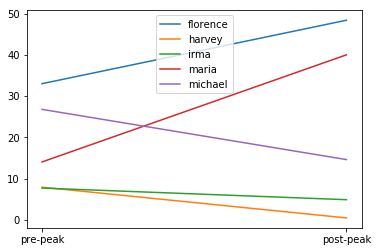

In [20]:
from statsmodels.stats.proportion import proportions_ztest
data_name_var = 'data_name_fixed'
date_var = 'date_day'
peak_var = 'data_peak_date'
anchor_var = 'anchor'
data_names = []
pre_pct = []
post_pct = []
for name_i, data_i in anchor_data.groupby(data_name_var):
    print('processing data %s'%(name_i))
    data_i_pre_peak = data_i[data_i.loc[:, 'pre_peak']==1]
    data_i_post_peak = data_i[data_i.loc[:, 'post_peak']==1]
    print('%d/%d'%(data_i_pre_peak.shape[0], data_i_post_peak.shape[0]))
    pre_anchor_count = data_i_pre_peak.loc[:, anchor_var].sum()
    post_anchor_count = data_i_pre_peak.loc[:, anchor_var].sum()
    pre_N = data_i_pre_peak.shape[0]
    post_N = data_i_post_peak.shape[0]
    pre_anchor_pct = pre_anchor_count / pre_N * 100
    post_anchor_pct = post_anchor_count / post_N * 100
    print('before peak: %.3f%% anchor'%(pre_anchor_pct))
    print('after peak: %.3f%% anchor'%(post_anchor_pct))
    post_pre_diff = (post_anchor_pct - pre_anchor_pct)
    test_stat, p_val = proportions_ztest([pre_anchor_count, post_anchor_count], [pre_N, post_N])
    print('diff %.3f with t=%.3f (p=%.3E)'%(post_pre_diff, test_stat, p_val))
    pre_pct.append(pre_anchor_pct)
    post_pct.append(post_anchor_pct)
    data_names.append(name_i)
## plot everything
for data_name_i, pre_i, post_i in zip(data_names, pre_pct, post_pct):
    plt.plot([0, 1], [pre_i, post_i], label=data_name_i)
plt.legend(loc='upper center')
plt.xticks([0, 1], ['pre-peak', 'post-peak'])
plt.show()

Same aggregate test but weighting all NEs equally.

processing data florence
3958/2806
before peak: 29.771% anchor
after peak: 22.501% anchor
diff -7.270 with t=2.500 (p=1.287E-02)
processing data harvey
3503/58813
before peak: 7.510% anchor
after peak: 11.589% anchor
diff 4.079 with t=-2.434 (p=1.531E-02)
processing data irma
21604/33740
before peak: 11.947% anchor
after peak: 11.025% anchor
diff -0.922 with t=0.927 (p=3.543E-01)
processing data maria
3614/1286
before peak: 13.474% anchor
after peak: 13.556% anchor
diff 0.082 with t=-0.027 (p=9.785E-01)
processing data michael
2101/4179
before peak: 22.047% anchor
after peak: 16.344% anchor
diff -5.703 with t=1.877 (p=6.150E-02)


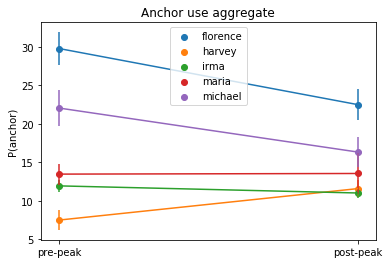

In [21]:
from statsmodels.stats.weightstats import ttest_ind
min_NE_count = 5
NE_var = 'NE_fixed'
anchor_var = 'anchor'
data_names = []
pre_pct = []
post_pct = []
for name_i, data_i in anchor_data.groupby(data_name_var):
    print('processing data %s'%(name_i))
    # restrict to consistent NEs
    NE_counts_i = data_i.loc[:, NE_var].value_counts()
    data_i = data_i[data_i.loc[:, NE_var].isin(NE_counts_i[NE_counts_i >= min_NE_count].index.tolist())]
    # separate pre/post peak
    data_i_pre_peak = data_i[data_i.loc[:, 'pre_peak']==1]
    data_i_post_peak = data_i[data_i.loc[:, 'post_peak']==1]
    print('%d/%d'%(data_i_pre_peak.shape[0], data_i_post_peak.shape[0]))
    # restrict to shared NEs
    NE_shared_i = set(data_i_pre_peak.loc[:, NE_var].unique()) & set(data_i_post_peak.loc[:, NE_var].unique())
    data_i_pre_peak = data_i_pre_peak[data_i_pre_peak.loc[:, NE_var].isin(NE_shared_i)]
    data_i_post_peak = data_i_post_peak[data_i_post_peak.loc[:, NE_var].isin(NE_shared_i)]    
    # compute percents
    pre_N = data_i_pre_peak.shape[0]
    post_N = data_i_post_peak.shape[0]
    pre_anchor_pct = data_i_pre_peak.groupby(NE_var).apply(lambda x: x.loc[:, anchor_var].sum() / x.shape[0]*100)
    post_anchor_pct = data_i_post_peak.groupby(NE_var).apply(lambda x: x.loc[:, anchor_var].sum() / x.shape[0]*100)
    print('before peak: %.3f%% anchor'%(pre_anchor_pct.mean()))
    print('after peak: %.3f%% anchor'%(post_anchor_pct.mean()))
    post_pre_diff = (post_anchor_pct.mean() - pre_anchor_pct.mean())
    test_stat, p_val, df = ttest_ind(pre_anchor_pct, post_anchor_pct)
    print('diff %.3f with t=%.3f (p=%.3E)'%(post_pre_diff, test_stat, p_val))
    pre_pct.append(pre_anchor_pct)
    post_pct.append(post_anchor_pct)
    data_names.append(name_i)
## plot everything
X = [0,1]
for data_name_i, pre_i, post_i in zip(data_names, pre_pct, post_pct):
    Y = [pre_i.mean(), post_i.mean()]
    Y_err = [pre_i.std() / len(pre_i)**.5, post_i.std() / len(post_i)**.5]
    plt.scatter(X, Y, label=data_name_i)
    plt.errorbar(X, Y, yerr=Y_err)
plt.legend(loc='upper center')
plt.xticks(X, ['pre-peak', 'post-peak'])
plt.ylabel('P(anchor)')
plt.title('Anchor use aggregate')
plt.show()

Minimal difference. Not great!

Same thing but with per-NE peak dates.

processing data florence
1645/3293
before peak: 26.272% anchor
after peak: 26.217% anchor
diff -0.055 with t=0.016 (p=9.871E-01)
processing data harvey
11315/39584
before peak: 10.178% anchor
after peak: 13.426% anchor
diff 3.248 with t=-1.864 (p=6.305E-02)
processing data irma
24384/13986
before peak: 11.375% anchor
after peak: 12.299% anchor
diff 0.924 with t=-0.808 (p=4.194E-01)
processing data maria
2282/1599
before peak: 9.320% anchor
after peak: 11.171% anchor
diff 1.851 with t=-0.695 (p=4.888E-01)
processing data michael
1509/3477
before peak: 23.611% anchor
after peak: 18.834% anchor
diff -4.777 with t=0.981 (p=3.289E-01)


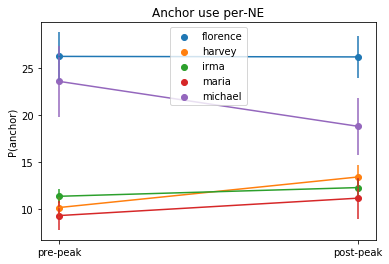

In [22]:
NE_var = 'NE_fixed'
anchor_var = 'anchor'
data_names = []
pre_pct = []
post_pct = []
for name_i, data_i in anchor_data_NE_peak.groupby(data_name_var):
    print('processing data %s'%(name_i))
    # separate pre/post peak
    data_i_pre_peak = data_i[data_i.loc[:, 'pre_peak']==1]
    data_i_post_peak = data_i[data_i.loc[:, 'post_peak']==1]
    print('%d/%d'%(data_i_pre_peak.shape[0], data_i_post_peak.shape[0]))
    # restrict to shared NEs
    NE_shared_i = set(data_i_pre_peak.loc[:, NE_var].unique()) & set(data_i_post_peak.loc[:, NE_var].unique())
    data_i_pre_peak = data_i_pre_peak[data_i_pre_peak.loc[:, NE_var].isin(NE_shared_i)]
    data_i_post_peak = data_i_post_peak[data_i_post_peak.loc[:, NE_var].isin(NE_shared_i)]    
    # compute percents
    pre_N = data_i_pre_peak.shape[0]
    post_N = data_i_post_peak.shape[0]
    pre_anchor_pct = data_i_pre_peak.groupby(NE_var).apply(lambda x: x.loc[:, anchor_var].sum() / x.shape[0]*100)
    post_anchor_pct = data_i_post_peak.groupby(NE_var).apply(lambda x: x.loc[:, anchor_var].sum() / x.shape[0]*100)
    print('before peak: %.3f%% anchor'%(pre_anchor_pct.mean()))
    print('after peak: %.3f%% anchor'%(post_anchor_pct.mean()))
    post_pre_diff = (post_anchor_pct.mean() - pre_anchor_pct.mean())
    test_stat, p_val, df = ttest_ind(pre_anchor_pct, post_anchor_pct)
    print('diff %.3f with t=%.3f (p=%.3E)'%(post_pre_diff, test_stat, p_val))
    pre_pct.append(pre_anchor_pct)
    post_pct.append(post_anchor_pct)
    data_names.append(name_i)
## plot everything
X = [0,1]
for data_name_i, pre_i, post_i in zip(data_names, pre_pct, post_pct):
    Y = [pre_i.mean(), post_i.mean()]
    Y_err = [pre_i.std() / len(pre_i)**.5, post_i.std() / len(post_i)**.5]
    plt.scatter(X, Y, label=data_name_i)
    plt.errorbar(X, Y, yerr=Y_err)
plt.legend(loc='upper center')
plt.xticks(X, ['pre-peak', 'post-peak'])
plt.ylabel('P(anchor)')
plt.title('Anchor use per-NE')
plt.show()

At the aggregate level, we actually see a slight increase in anchoring for almost all data except (!) `Michael`.

Same test but for low-importance and high-importance NEs.

In [23]:
importance_var = 'max_population'
anchor_data_NE_peak = anchor_data_NE_peak.assign(**{'%s_log'%(importance_var) : anchor_data_NE_peak.loc[:, importance_var].apply(lambda x: np.log(x+1.))})

testing NEs with importance 0-50
processing data florence
2472/6539 NEs by importance
476/1354
before peak: 27.276% anchor
after peak: 24.429% anchor
diff -2.847 with t=0.595 (p=5.543E-01)
processing data harvey
10365/67882 NEs by importance
2499/3921
before peak: 11.521% anchor
after peak: 15.989% anchor
diff 4.468 with t=-1.565 (p=1.192E-01)
processing data irma
16379/58922 NEs by importance
4484/4080
before peak: 12.222% anchor
after peak: 13.009% anchor
diff 0.787 with t=-0.423 (p=6.727E-01)
processing data maria
1038/5761 NEs by importance
324/415
before peak: 7.171% anchor
after peak: 11.358% anchor
diff 4.187 with t=-1.320 (p=1.947E-01)
processing data michael
4702/6448 NEs by importance
1181/2451
before peak: 22.111% anchor
after peak: 20.049% anchor
diff -2.062 with t=0.332 (p=7.413E-01)


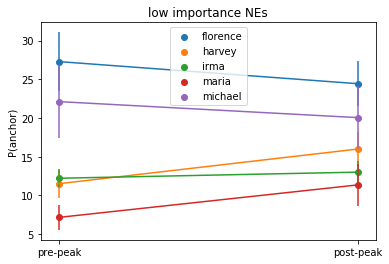

testing NEs with importance 50-100
processing data florence
4023/6539 NEs by importance
1149/1923
before peak: 26.110% anchor
after peak: 28.534% anchor
diff 2.424 with t=-0.494 (p=6.225E-01)
processing data harvey
57458/67882 NEs by importance
8781/35648
before peak: 8.950% anchor
after peak: 11.022% anchor
diff 2.072 with t=-1.032 (p=3.032E-01)
processing data irma
42382/58922 NEs by importance
19834/9893
before peak: 10.590% anchor
after peak: 11.660% anchor
diff 1.069 with t=-0.803 (p=4.223E-01)
processing data maria
4688/5761 NEs by importance
1936/1182
before peak: 12.073% anchor
after peak: 11.562% anchor
diff -0.511 with t=0.115 (p=9.093E-01)
processing data michael
1708/6448 NEs by importance
324/1004
before peak: 25.971% anchor
after peak: 18.506% anchor
diff -7.465 with t=0.976 (p=3.342E-01)


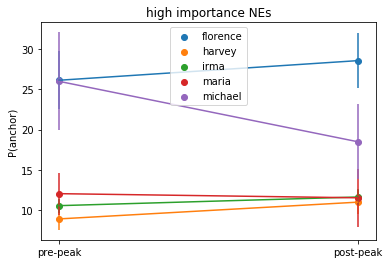

In [24]:
importance_var = 'max_population_log'
NE_var = 'NE_fixed'
anchor_var = 'anchor'
importance_cutoffs = [[0, 50], [50,100]]
importance_types = ['low', 'high']
for importance_type, (importance_low_pct, importance_high_pct) in zip(importance_types, importance_cutoffs):
    print('testing NEs with importance %d-%d'%(importance_low_pct, importance_high_pct))
    data_names = []
    pre_pct = []
    post_pct = []
    for name_i, data_i in anchor_data_NE_peak.groupby(data_name_var):
        print('processing data %s'%(name_i))
        # split by importance
        data_i_dedup = data_i.drop_duplicates(NE_var, inplace=False)
        importance_low = np.percentile(data_i_dedup.loc[:, importance_var], importance_low_pct)
        importance_high = np.percentile(data_i_dedup.loc[:, importance_var], importance_high_pct)
        NE_relevant_i = data_i_dedup[(data_i_dedup.loc[:, importance_var] >= importance_low) &
                                     (data_i_dedup.loc[:, importance_var] < importance_high)].loc[:, NE_var].unique()
#         print('%d relevant NE with importance=(%.3f, %.3f)'%(len(NE_relevant_i), importance_low, importance_high))
        N = data_i.shape[0]
        data_i = data_i[data_i.loc[:, NE_var].isin(NE_relevant_i)]
        print('%d/%d NEs by importance'%(data_i.shape[0], N))
        # separate pre/post peak
        data_i_pre_peak = data_i[data_i.loc[:, 'pre_peak']==1]
        data_i_post_peak = data_i[data_i.loc[:, 'post_peak']==1]
        print('%d/%d'%(data_i_pre_peak.shape[0], data_i_post_peak.shape[0]))
        # restrict to shared NEs
        NE_shared_i = set(data_i_pre_peak.loc[:, NE_var].unique()) & set(data_i_post_peak.loc[:, NE_var].unique())
        data_i_pre_peak = data_i_pre_peak[data_i_pre_peak.loc[:, NE_var].isin(NE_shared_i)]
        data_i_post_peak = data_i_post_peak[data_i_post_peak.loc[:, NE_var].isin(NE_shared_i)]    
        # compute percents
        pre_N = data_i_pre_peak.shape[0]
        post_N = data_i_post_peak.shape[0]
        pre_anchor_pct = data_i_pre_peak.groupby(NE_var).apply(lambda x: x.loc[:, anchor_var].sum() / x.shape[0]*100)
        post_anchor_pct = data_i_post_peak.groupby(NE_var).apply(lambda x: x.loc[:, anchor_var].sum() / x.shape[0]*100)
        print('before peak: %.3f%% anchor'%(pre_anchor_pct.mean()))
        print('after peak: %.3f%% anchor'%(post_anchor_pct.mean()))
        post_pre_diff = (post_anchor_pct.mean() - pre_anchor_pct.mean())
        test_stat, p_val, df = ttest_ind(pre_anchor_pct, post_anchor_pct)
        print('diff %.3f with t=%.3f (p=%.3E)'%(post_pre_diff, test_stat, p_val))
        pre_pct.append(pre_anchor_pct)
        post_pct.append(post_anchor_pct)
        data_names.append(name_i)
    ## plot everything
    X = [0,1]
    for data_name_i, pre_i, post_i in zip(data_names, pre_pct, post_pct):
        Y = [pre_i.mean(), post_i.mean()]
        Y_err = [pre_i.std() / len(pre_i)**.5, post_i.std() / len(post_i)**.5]
        plt.scatter(X, Y, label=data_name_i)
        plt.errorbar(X, Y, yerr=Y_err)
    plt.legend(loc='upper center')
    plt.xticks(X, ['pre-peak', 'post-peak'])
    plt.ylabel('P(anchor)')
    plt.title('%s importance NEs'%(importance_type))
    plt.show()

## Control for entity and author effects with regression
Can we control for entity-level and author-level effects too? An influx of non-local authors could be driving the overall increase effect.

Let's set this up as a regression:

anchor ~ NE + author + pre_peak + post_peak + $\epsilon$

Let's do one regression per data set first.

In [25]:
from statsmodels.discrete.discrete_model import Logit
author_var = 'username'
NE_var = 'NE_fixed'
time_vars = ['pre_peak', 'post_peak']
data_name_var = 'data_name_fixed'
dep_var = 'anchor'
formula = '%s ~ C(%s) + %s'%(dep_var, NE_var, ' + '.join(time_vars)) # control NEs
# formula = '%s ~ C(%s) + %s'%(dep_var, author_var, ' + '.join(time_vars)) # control authors
# formula = '%s ~ C(%s) + C(%s) + C(%s) + %s'%(dep_var, data_name_var, NE_var, author_var, ' + '.join(time_vars)) # control NEs, authors

## per-dataset
min_author_pre_post = 1
min_NE_author_count = 2
min_NE_count = 2
for name_i, data_i in anchor_data_NE_peak.groupby(data_name_var):
    print('data = %s'%(name_i))
    # restrict to consistent authors
    author_pre_counts_i = data_i[data_i.loc[:, 'pre_peak']==1].loc[:, author_var].value_counts()
    author_post_counts_i = data_i[data_i.loc[:, 'post_peak']==1].loc[:, author_var].value_counts()
    consistent_authors_i = set(author_pre_counts_i[author_pre_counts_i >= min_author_pre_post].index) & set(author_post_counts_i[author_post_counts_i >= min_author_pre_post].index)
#     author_anchor_i = data_i.groupby(author_var).apply(lambda x: x.loc[:, anchor_var].mean())
#     consistent_authors_i = author_anchor_i[author_anchor_i > 0.].index.tolist()
#     author_counts_i = data_i.loc[:, author_var].value_counts()
#     consistent_authors_i = set(author_counts_i[author_counts_i >= min_author_post_count].index.tolist())
    # restrict to consistent NEs
#     NE_counts_i = data_i.loc[:, NE_var].value_counts()
#     NE_consistent_i = NE_counts_i[NE_counts_i >= min_NE_count]
#     print('%d/%d consistent authors'%(len(consistent_authors_i), len(author_counts_i)))
    data_i = data_i[data_i.loc[:, author_var].isin(consistent_authors_i)]
    print('%d/%d consistent authors'%(len(consistent_authors_i), len(author_pre_counts_i)))
    
    # remove peak data
#     data_i = data_i[(data_i.loc[:, 'pre_peak'] == 1) | (data_i.loc[:, 'post_peak'] == 1)]
    
    # restrict to consistent NEs
#     consistent_NE_i = data_i.groupby(NE_var).apply(lambda x: (x.loc[:, 'pre_peak'].sum() >= min_NE_count) & (x.loc[:, 'post_peak'].sum() >= min_NE_count))
#     consistent_NE_i = consistent_NE_i[consistent_NE_i].index.tolist()
#     NE_anchor_i = data_i.groupby(NE_var).apply(lambda x: x.loc[:, anchor_var].mean())
#     consistent_NE_i = NE_anchor_i[NE_anchor_i > 0.].index.tolist()
#     print('%d/%d consistent NEs'%(len(consistent_NE_i), data_i.loc[:, NE_var].nunique()))
#     data_i = data_i[data_i.loc[:, NE_var].isin(consistent_NE_i)]
    
    # restrict to NEs that have more than one author
#     NE_author_counts_i = data_i.groupby(NE_var).apply(lambda x: x.loc[:, author_var].nunique())
#     NE_author_consistent_i = set(NE_author_counts_i[NE_author_counts_i >= min_NE_author_count].index.tolist())
#     data_i = data_i[data_i.loc[:, NE_var].isin(NE_author_consistent_i)]
#     print('%d/%d consistent NEs'%(len(NE_author_consistent_i), len(NE_anchor_counts_i)))

    # debug: get combo counts
#     combo_counts_i = data_i.groupby([NE_var, author_var] + time_vars + [dep_var]).apply(lambda x: x.shape[0])
#     print(combo_counts_i)
    print('N=%d'%(data_i.shape[0]))
    model_i = Logit.from_formula(formula, data_i)
#     model_res_i = model_i.fit(method='bfgs')
    # use regularization to prevent overfitting
    model_res_i = model_i.fit_regularized(method='l1')
    print(model_res_i.summary())

data = florence
229/1120 consistent authors
N=1473
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.500211984687384
            Iterations: 370
            Function evaluations: 370
            Gradient evaluations: 370
                           Logit Regression Results                           
Dep. Variable:                 anchor   No. Observations:                 1473
Model:                          Logit   Df Residuals:                     1399
Method:                           MLE   Df Model:                           73
Date:                Tue, 25 Jun 2019   Pseudo R-squ.:                 0.09925
Time:                        17:32:36   Log-Likelihood:                -736.81
converged:                       True   LL-Null:                       -818.00
Covariance Type:            nonrobust   LLR p-value:                 9.530e-09
                                         coef    std err          z      P>|z|      [0.025      0.975]
-

2019/7851 consistent authors
N=14894
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.28699591841554156
            Iterations: 597
            Function evaluations: 598
            Gradient evaluations: 597
                           Logit Regression Results                           
Dep. Variable:                 anchor   No. Observations:                14894
Model:                          Logit   Df Residuals:                    14679
Method:                           MLE   Df Model:                          214
Date:                Tue, 25 Jun 2019   Pseudo R-squ.:                  0.1740
Time:                        17:34:52   Log-Likelihood:                -4274.5
converged:                       True   LL-Null:                       -5174.9
Covariance Type:            nonrobust   LLR p-value:                1.348e-248
                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.28418749372340724
            Iterations: 655
            Function evaluations: 655
            Gradient evaluations: 655
                           Logit Regression Results                           
Dep. Variable:                 anchor   No. Observations:                16425
Model:                          Logit   Df Residuals:                    16104
Method:                           MLE   Df Model:                          320
Date:                Tue, 25 Jun 2019   Pseudo R-squ.:                  0.1220
Time:                        17:45:14   Log-Likelihood:                -4667.8
converged:                       True   LL-Null:                       -5316.4
Covariance Type:            nonrobust   LLR p-value:                1.184e-117
                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3024579228323501
            Iterations: 179
            Function evaluations: 179
            Gradient evaluations: 179
                           Logit Regression Results                           
Dep. Variable:                 anchor   No. Observations:                  843
Model:                          Logit   Df Residuals:                      803
Method:                           MLE   Df Model:                           39
Date:                Tue, 25 Jun 2019   Pseudo R-squ.:                  0.1225
Time:                        17:45:14   Log-Likelihood:                -254.97
converged:                       True   LL-Null:                       -290.58
Covariance Type:            nonrobust   LLR p-value:                  0.001236
                                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

In [26]:
## joint model, one peak per dataset
print('testing joint model')
formula = '%s ~ C(%s) + C(%s) + %s'%(dep_var, data_name_var, NE_var, ' + '.join(time_vars))
# formula = '%s ~ C(%s) + C(%s) + C(%s) + %s'%(dep_var, data_name_var, author_var, NE_var, ' + '.join(time_vars))
model_full = Logit.from_formula(formula, anchor_data)
model_res_full = model_full.fit(method='bfgs')
print(model_res_full.summary())

testing joint model
         Current function value: 0.329415
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                 anchor   No. Observations:               163366
Model:                          Logit   Df Residuals:                   159169
Method:                           MLE   Df Model:                         4196
Date:                Tue, 25 Jun 2019   Pseudo R-squ.:                 0.08729
Time:                        18:07:08   Log-Likelihood:                -53815.
converged:                      False   LL-Null:                       -58962.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -1.2175      1.511     -0.806      0.420      -4.180       1.745
C(data_name_fixed)[T.harvey] 

In [27]:
## joint model, one peak per dataset-entity
print('testing joint model')
formula = '%s ~ C(%s) + C(%s) + %s'%(dep_var, data_name_var, NE_var, ' + '.join(time_vars))
model_full = Logit.from_formula(formula, anchor_data_NE_peak)
model_res_full = model_full.fit(method='bfgs')
print(model_res_full.summary())

testing joint model
         Current function value: 0.321503
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                 anchor   No. Observations:               145552
Model:                          Logit   Df Residuals:                   144950
Method:                           MLE   Df Model:                          601
Date:                Tue, 25 Jun 2019   Pseudo R-squ.:                 0.09902
Time:                        18:09:51   Log-Likelihood:                -46795.
converged:                      False   LL-Null:                       -51938.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -0.9573      0.341     -2.811      0.005      -1.625      -0.290
C(data_name_fixed)[T.harvey]          -0.7972      0.091   

We have to force regression to work using BFGS, which isn't great.

We see some significant effects in the joint data regression:
- `pre_peak` => negative
- some intuitive entity correlations => `wilmington` weak positive, `tampa` weak negative, `miami` negative, `dallas` weak negative, `naples` positive, `rockport` positive
- some intuitive data correlations => `michael` weak negative (because fewer people know about Florida Panhandle than about rest of Florida for `irma`)

### Filter authors
Let's try to do a basic form of regularization here on the fixed effects. We will collapse all low-count authors to a single category to cut down on the long tail.

In [28]:
min_author_count = 10
author_var = 'username'
data_name_var = 'data_name_fixed'
anchor_data_NE_peak_filter = []
for name_i, data_i in anchor_data_NE_peak.groupby(data_name_var):
    author_counts = data_i.loc[:, author_var].value_counts()
    NE_counts = data_i.loc[:, NE_var].value_counts()
    # filter authors
    data_i = data_i.assign(**{author_var : data_i.loc[:, author_var].apply(lambda x: 'RARE_AUTHOR' if author_counts.loc[x] < min_author_count else x)})
    # filter NEs - we already filtered when preprocessing
#     data_i = data_i.assign(**{NE_var : data_i.loc[:, NE_var].apply(lambda x: 'RARE_NE' if NE_counts.loc[x] < min_NE_count else x)})
    anchor_data_NE_peak_filter.append(data_i)
anchor_data_NE_peak_filter = pd.concat(anchor_data_NE_peak_filter, axis=0)
display(anchor_data_NE_peak_filter.loc[:, author_var].value_counts().head(20))
# display(anchor_data_NE_peak_filter.loc[:, NE_var].value_counts())

RARE_AUTHOR        120204
SimpleWeatherFL       428
kkfla737              180
windiewx              156
statesman             152
SimpleWeatherGA       133
channel1america       132
JRiz11                131
XRIM                  125
torrea40              117
BN9                   113
BreakingNNow          108
NBCNightlyNews        108
REALDANIELGLENN       106
EcoInternetDrGB       103
ABC                   103
CyberAnonymous         99
postandcourier         96
hurrtrackerapp         95
reportermatt           95
Name: username, dtype: int64

Let's try the full fixed effect again.

In [29]:
from statsmodels.discrete.discrete_model import Logit
author_var = 'username'
NE_var = 'NE_fixed'
time_vars = ['pre_peak', 'post_peak']
data_name_var = 'data_name_fixed'
dep_var = 'anchor'
formula = '%s ~ C(%s) + C(%s) + C(%s) + %s'%(dep_var, data_name_var, author_var, NE_var, ' + '.join(time_vars))
model_full = Logit.from_formula(formula, anchor_data_NE_peak_filter)
model_res_full = model_full.fit(method='bfgs', maxiter=100)
print(model_res_full.summary())

         Current function value: 0.304381
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101


/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                 anchor   No. Observations:               145552
Model:                          Logit   Df Residuals:                   143805
Method:                           MLE   Df Model:                         1746
Date:                Tue, 25 Jun 2019   Pseudo R-squ.:                  0.1470
Time:                        18:23:22   Log-Likelihood:                -44303.
converged:                      False   LL-Null:                       -51938.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -1.0482      0.864     -1.213      0.225      -2.742       0.646
C(data_name_fixed)[T.harvey]          -1.0676      0.099   

### Fixed effect regression, regularized

We should try regularization to see if it cleans up the parameter space.

In [30]:
# %%capture model_output
np.random.seed(123)
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families.family import Binomial
from statsmodels.genmod.families.links import logit
from math import floor, ceil

## logit math stolen from source code
## http://www.statsmodels.org/stable/_modules/statsmodels/discrete/discrete_model.html#Logit.loglikeobs

## logit cdf
def logit_cdf(X):
    return 1 / (1 + np.exp(-X))

## log likelihood
def compute_log_likelihood(params, Y, X):
    q = 2 * Y - 1
    ll = np.sum(np.log(logit_cdf(q * np.dot(X, params))))
    return ll

author_var = 'username'
NE_var = 'NE_fixed'
time_vars = ['pre_peak', 'post_peak']
data_name_var = 'data_name_fixed'
dep_var = 'anchor'
formula = '%s ~ C(%s) + C(%s) + C(%s) + %s'%(dep_var, data_name_var, author_var, NE_var, ' + '.join(time_vars))

max_iter = 25
# vanilla fit
# model_res_full = model_full.fit(method='bfgs', maxiter=max_iter)

# regularized fit
## TODO: tune hyperparameter with cross-validation on P(test_data)...ugh
l2_weights = [0., 0.01, 0.1, 1.]
anchor_data_NE_peak_filter_rand = anchor_data_NE_peak_filter.copy() 
np.random.shuffle(anchor_data_NE_peak_filter_rand.values)
# convert to exogenous data
# need to do this to force train/test
# to have same columns
model_dummy = GLM.from_formula(formula, anchor_data_NE_peak_filter_rand, family=Binomial(link=logit()))
exog = model_dummy.exog
exog_names = model_dummy.exog_names
endog = model_dummy.endog
# generate cross validation folds
cross_val_folds = 10
N = anchor_data_NE_peak_filter_rand.shape[0]
cross_val_chunk_size = float(N) / cross_val_folds
cross_val_fold_train_idx = [list(range(int(floor(i*cross_val_chunk_size)), int(ceil((i+1)*cross_val_chunk_size)))) for i in range(cross_val_folds)]
cross_val_fold_test_idx = [list(range(0, int(ceil(i*cross_val_chunk_size)))) + list(range(int(floor((i+1)*cross_val_chunk_size)), N)) for i in range(cross_val_folds)]
weight_likelihoods = []
for l2_weight in l2_weights:
    print('testing weight = %.3f'%(l2_weight))
    likelihoods_l2 = []
    for i, (train_idx_i, test_idx_i) in enumerate(zip(cross_val_fold_train_idx, cross_val_fold_test_idx)):
        print('fold %d'%(i))
        train_XY = anchor_data_NE_peak_filter_rand.iloc[train_idx_i, :]
        test_X = exog[test_idx_i, :]
        test_Y = endog[test_idx_i]
#         train_i = anchor_data_NE_peak_filter_rand.iloc[train_idx_i, :]
#         test_i = anchor_data_NE_peak_filter_rand.iloc[test_idx_i, :]
        # fit model
        model_i = GLM.from_formula(formula, train_XY, family=Binomial(link=logit()))
        model_res_i = model_i.fit_regularized(maxiter=max_iter, method='elastic_net', alpha=l2_weight, L1_wt=0.)
        # add 0 params for missing coefficients
        # to match X shape
        model_res_i.params = model_res_i.params.loc[exog_names].fillna(0, inplace=False)
        # score test data
        # implement this: http://www.statsmodels.org/stable/_modules/statsmodels/discrete/discrete_model.html#Logit.loglikeobs
        likelihood_i = compute_log_likelihood(model_res_i.params, test_Y, test_X)
        likelihoods_l2.append(likelihood_i)
    weight_likelihoods.append(likelihoods_l2)
weight_likelihoods = np.array(weight_likelihoods)

testing weight = 0.000
fold 0


/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:1303: UserWarning: GLM ridge optimization may have failed, |grad|=0.000219
  warnings.warn(msg)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


fold 1
fold 2


/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:1303: UserWarning: GLM ridge optimization may have failed, |grad|=0.000201
  warnings.warn(msg)


fold 3


/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:1303: UserWarning: GLM ridge optimization may have failed, |grad|=0.000575
  warnings.warn(msg)


fold 4


/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:1303: UserWarning: GLM ridge optimization may have failed, |grad|=0.000572
  warnings.warn(msg)


fold 5


/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:1303: UserWarning: GLM ridge optimization may have failed, |grad|=0.001093
  warnings.warn(msg)


fold 6


/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:1303: UserWarning: GLM ridge optimization may have failed, |grad|=0.000995
  warnings.warn(msg)


fold 7


/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:1303: UserWarning: GLM ridge optimization may have failed, |grad|=0.001041
  warnings.warn(msg)


fold 8


/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:1303: UserWarning: GLM ridge optimization may have failed, |grad|=0.000529
  warnings.warn(msg)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


fold 9


/nethome/istewart6/.local/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:1303: UserWarning: GLM ridge optimization may have failed, |grad|=0.000587
  warnings.warn(msg)


testing weight = 0.010
fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
testing weight = 0.100
fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
testing weight = 1.000
fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


In [40]:
weight_likelihoods = pd.DataFrame(weight_likelihoods, index=l2_weights)
print(weight_likelihoods.mean(axis=1))

0.00   -103707.838351
0.01    -48211.315910
0.10    -51456.305366
1.00    -69904.850750
dtype: float64


Let's pass the best L2 weight value to the full model.

In [41]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families.family import Binomial
from statsmodels.genmod.families.links import logit
author_var = 'username'
NE_var = 'NE_fixed'
time_vars = ['pre_peak', 'post_peak']
data_name_var = 'data_name_fixed'
dep_var = 'anchor'
formula = '%s ~ C(%s) + C(%s) + C(%s) + %s'%(dep_var, data_name_var, author_var, NE_var, ' + '.join(time_vars))
## fit full data with best hyperparam in terms of LL
l2_weight = 0.01
max_iter = 100
model_full = GLM.from_formula(formula, anchor_data_NE_peak_filter, family=Binomial(link=logit()))
model_res_full = model_full.fit_regularized(maxiter=max_iter, method='elastic_net', alpha=l2_weight, L1_wt=0.0)
# summary not implemented...we have to compute SE from covariance
# print(model_res_full.summary())

TODO: Did the model converge? We can't tell from the output alone.

We have to compute the standard errors on the parameters to determine significance. We do this by computing $C = (X^{T}VX)^{-1}$ where X is the design matrix (exogenous variables including intercept) and V is the diagonal matrix in which the diagonal is the expected value of the samples.

In [42]:
from scipy.stats import norm, chi
from scipy.sparse import diags, csr_matrix, linalg
def compute_err_data(model_results):
    exog_names = model_results.model.exog_names
    design_mat = model_results.model.exog
    pred_probs = model_results.model.predict(model_results.params)
    # need sparse matrix! to avoid memory explosion
    prob_mat = diags(pred_probs, 0).tocsr()
    design_mat = csr_matrix(design_mat)
    cov_mat = linalg.inv(design_mat.T.dot(prob_mat).dot(design_mat))
    param_err = np.sqrt(np.diag(cov_mat.todense()))
    model_err_data = pd.DataFrame(model_results.params, columns=['mean'])
    model_err_data = model_err_data.assign(**{'SE' : param_err})
    # compute test stat, p-val for two-sided test
    # https://stats.stackexchange.com/questions/60074/wald-test-for-logistic-regression
    model_err_data = model_err_data.assign(**{'z_score' : model_err_data.loc[:, 'mean'] / model_err_data.loc[:, 'SE']})
    # use Wald test
    model_err_data = model_err_data.assign(**{'p_val' : model_err_data.loc[:, 'z_score'].apply(lambda x: 1-chi.cdf(x**2, 1))})
    # model_err_data = model_err_data.assign(**{'p_val' : model_err_data.loc[:, 'z_score'].apply(lambda x: norm.cdf(x))})
    # confidence intervals
    alpha = 0.05
    Z_alpha = norm.ppf(1-alpha/2)
    model_err_data = model_err_data.assign(**{'conf_%.1f'%(alpha/2*100) : model_err_data.loc[:, 'mean'] - Z_alpha*model_err_data.loc[:, 'SE']})
    model_err_data = model_err_data.assign(**{'conf_%.1f'%((1-alpha/2)*100) : model_err_data.loc[:, 'mean'] + Z_alpha*model_err_data.loc[:, 'SE']})
    # model_err_data = model_err_data.assign(**{'p_val' : norm.cdf(model_err_data.loc[:, 't_score'])})
    return model_err_data

In [43]:
model_err_data = compute_err_data(model_res_full)
display(model_err_data)

,mean,SE,z_score,p_val,conf_2.5,conf_97.5
Intercept,-0.872959,0.627433,-1.391318,0.052896,-2.102704,0.356787
C(data_name_fixed)[T.harvey],-0.508554,0.085729,-5.932099,0.000000,-0.676580,-0.340528
C(data_name_fixed)[T.irma],-0.619587,0.075328,-8.225148,0.000000,-0.767228,-0.471946
C(data_name_fixed)[T.maria],-0.232371,0.198724,-1.169316,0.171531,-0.621862,0.157120
C(data_name_fixed)[T.michael],0.052334,0.096770,0.540811,0.769922,-0.137331,0.242000
C(username)[T.10NewsWTSP],-0.001505,0.785734,-0.001915,0.999997,-1.541516,1.538506
C(username)[T.11AliveNews],-0.000493,0.945687,-0.000522,1.000000,-1.854006,1.853020
C(username)[T.12NewsNow],-0.002049,0.811700,-0.002524,0.999995,-1.592951,1.588853
C(username)[T.1legalcom],-0.000980,1.005055,-0.000976,0.999999,-1.970852,1.968891
C(username)[T.247NewsHQ],0.010019,0.725267,0.013815,0.999848,-1.411478,1.431517


We see similar results to above, although with fewer significant effects (only 2/5 data sets have nonzero effects).

Let's see which authors/locations had significant effects.

In [44]:
from statsmodels.stats.multitest import multipletests
p_val_upper = 0.05
model_err_data_corrected = multipletests(model_err_data.loc[:, 'p_val'], method='sidak')[1]
print([model_err_data.iloc[i, :] for i in np.where(model_err_data_corrected < p_val_upper)])

[                                  mean        SE    z_score         p_val  \
C(data_name_fixed)[T.harvey] -0.508554  0.085729  -5.932099  0.000000e+00   
C(data_name_fixed)[T.irma]   -0.619587  0.075328  -8.225148  0.000000e+00   
C(NE_fixed)[T.houston]       -0.760797  0.295465  -2.574915  3.352563e-11   
pre_peak                     -0.294669  0.020700 -14.235294  0.000000e+00   
post_peak                    -0.264036  0.019270 -13.702079  0.000000e+00   

                              conf_2.5  conf_97.5  
C(data_name_fixed)[T.harvey] -0.676580  -0.340528  
C(data_name_fixed)[T.irma]   -0.767228  -0.471946  
C(NE_fixed)[T.houston]       -1.339897  -0.181697  
pre_peak                     -0.335240  -0.254098  
post_peak                    -0.301804  -0.226268  ]


OK! The elastic net objective has reduced all coefficients to nearly zero, except for one of the data sets and the time variables (the most important!).

Let's plot the before/after effects for posterity.

In [45]:
def plot_effects(data, effect_vars=['pre_peak', 'post_peak'], mean_var='mean', se_var='SE', coeff_var='Effect'):
    # plot effect and standard error
    X = np.arange(len(effect_vars))
    Y = data.loc[effect_vars, mean_var]
    Y_err = data.loc[effect_vars, se_var]
    plt.scatter(X, Y, c='b', marker='o')
    plt.errorbar(X, Y, yerr=Y_err, c='b', ls='none')
    plt.xticks(X, effect_vars)
    plt.ylabel(coeff_var, usetex=True)
    plt.title('Regression effects')
    plt.show()

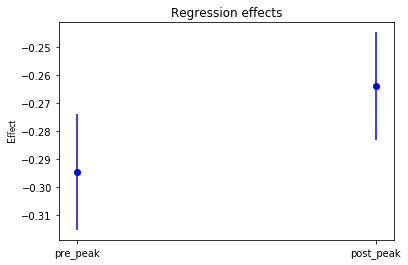

In [46]:
plot_effects(model_err_data)

## Fixed effect regression, plus post-peak time
What if we try to model not just pre/post-peak but also the amount of time since post-peak? This would help us tease out the long-term effect of collective attention on context.

In [47]:
post_peak_time_var = 'since_post_peak'
day_buffer = 1
anchor_data_NE_peak_filter = anchor_data_NE_peak_filter.assign(**{post_peak_time_var : anchor_data_NE_peak_filter.loc[:, 'post_peak']*((anchor_data_NE_peak_filter.loc[:, 'date_day'] - anchor_data_NE_peak_filter.loc[:, 'NE_peak_date']).apply(lambda x: x.days) - day_buffer)})

In [48]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families.family import Binomial
from statsmodels.genmod.families.links import logit
author_var = 'username'
NE_var = 'NE_fixed'
time_vars = ['pre_peak', 'post_peak', 'since_post_peak']
data_name_var = 'data_name_fixed'
dep_var = 'anchor'
formula = '%s ~ C(%s) + C(%s) + C(%s) + %s'%(dep_var, data_name_var, author_var, NE_var, ' + '.join(time_vars))
## fit full data with best hyperparam in terms of LL
l2_weight = 0.01
max_iter = 100
model_full = GLM.from_formula(formula, anchor_data_NE_peak_filter, family=Binomial(link=logit()))
model_res_full = model_full.fit_regularized(maxiter=max_iter, method='elastic_net', alpha=l2_weight, L1_wt=0.0)

In [49]:
model_err_data = compute_err_data(model_res_full)
display(model_err_data)

,mean,SE,z_score,p_val,conf_2.5,conf_97.5
Intercept,-0.865796,0.625777,-1.383554,0.055592,-2.092296,0.360704
C(data_name_fixed)[T.harvey],-0.506308,0.085954,-5.890460,0.000000,-0.674775,-0.337842
C(data_name_fixed)[T.irma],-0.625730,0.075584,-8.278621,0.000000,-0.773871,-0.477588
C(data_name_fixed)[T.maria],-0.228203,0.199132,-1.145990,0.189084,-0.618495,0.162088
C(data_name_fixed)[T.michael],0.056591,0.096828,0.584447,0.732669,-0.133189,0.246371
C(username)[T.10NewsWTSP],-0.001515,0.783240,-0.001934,0.999997,-1.536637,1.533607
C(username)[T.11AliveNews],-0.000493,0.944429,-0.000522,1.000000,-1.851540,1.850553
C(username)[T.12NewsNow],-0.001994,0.815674,-0.002445,0.999995,-1.600687,1.596698
C(username)[T.1legalcom],-0.000976,1.005347,-0.000971,0.999999,-1.971420,1.969467
C(username)[T.247NewsHQ],0.010015,0.723376,0.013844,0.999847,-1.407777,1.427806


Weird! Adding the post-peak time variable changes the story: less likely to anchor before the peak, more likely to anchor after the peak, less likely to anchor over time after the peak.

Let's plot the average predicted probability over time to get the full story.

In [63]:
# compute average number of days active for a given entity
data_name_var = 'data_name_fixed'
NE_var = 'NE_fixed'
# we want date ranges for pre-peak and post-peak
NE_pre_peak_time = anchor_data_NE_peak_filter[anchor_data_NE_peak_filter.loc[:, 'pre_peak']==1].groupby([data_name_var, NE_var]).apply(lambda x: (x.loc[:, date_var].max() - x.loc[:, date_var].min()).days)
NE_post_peak_time = anchor_data_NE_peak_filter[anchor_data_NE_peak_filter.loc[:, 'post_peak']==1].groupby([data_name_var, NE_var]).apply(lambda x: (x.loc[:, date_var].max() - x.loc[:, date_var].min()).days)
NE_pre_peak_time = NE_pre_peak_time.reset_index().rename(columns={0 : 'count'})
NE_post_peak_time = NE_post_peak_time.reset_index().rename(columns={0 : 'count'})
# display(NE_post_peak_time.head())
NE_pre_peak_mean = NE_pre_peak_time.loc[:, 'count'].mean()
NE_post_peak_mean = NE_post_peak_time.loc[:, 'count'].mean()
print('mean NE pre-peak time = %.3f +/- %.3f'%(NE_pre_peak_mean, NE_pre_peak_time.loc[:, 'count'].std()))
print('mean NE post-peak time = %.3f +/- %.3f'%(NE_post_peak_mean, NE_post_peak_time.loc[:, 'count'].std()))

mean NE pre-peak time = 4.557 +/- 4.410
mean NE post-peak time = 7.323 +/- 5.079


In [69]:
# predict probability for (1) pre-peak (2) post-peak (3) days since post-peak
# let's do this the right way first: predict prob for all data, sort by date, plot by relative time
# might need a bootstrap to plot uncertainty ex. https://stackoverflow.com/questions/47414842/confidence-interval-of-probability-prediction-from-logistic-regression-statsmode#47419474
anchor_data_NE_peak_filter_probs = model_res_full.model.predict(model_res_full.params)
print(anchor_data_NE_peak_filter_probs.mean())
print(model_res_full.model.endog.mean())

0.12365397267307471
0.11499670220951962


In [78]:
# add pre-peak time for plotting
pre_peak_time_var = 'till_pre_peak'
day_buffer = 1
anchor_data_NE_peak_filter = anchor_data_NE_peak_filter.assign(**{pre_peak_time_var : anchor_data_NE_peak_filter.loc[:, 'pre_peak']*((anchor_data_NE_peak_filter.loc[:, 'NE_peak_date'] - anchor_data_NE_peak_filter.loc[:, 'date_day']).apply(lambda x: x.days) - day_buffer)})

In [80]:
# combine data
time_vars = ['pre_peak', 'post_peak', 'till_pre_peak', 'since_post_peak']
anchor_data_NE_peak_filter_prob_data = pd.DataFrame(anchor_data_NE_peak_filter_probs, index=anchor_data_NE_peak_filter.index).rename(columns={0:'prob'})
anchor_data_NE_peak_filter_prob_data = pd.concat([anchor_data_NE_peak_filter_prob_data, anchor_data_NE_peak_filter.loc[:, time_vars]], axis=1)
# let's invert the till_peak var for easier plotting
anchor_data_NE_peak_filter_prob_data = anchor_data_NE_peak_filter_prob_data.assign(**{'till_pre_peak' : anchor_data_NE_peak_filter_prob_data.loc[:, 'till_pre_peak']*-1})
# combine into single time column
anchor_data_NE_peak_filter_prob_data = anchor_data_NE_peak_filter_prob_data.assign(**{'relative_date' : anchor_data_NE_peak_filter_prob_data.loc[:, 'till_pre_peak'] + anchor_data_NE_peak_filter_prob_data.loc[:, 'since_post_peak']})
display(anchor_data_NE_peak_filter_prob_data.head())

,prob,pre_peak,post_peak,till_pre_peak,since_post_peak,relative_date
0,0.190575,1,0,-14,0,-14
1,0.190575,1,0,-7,0,-7
2,0.190575,1,0,-6,0,-6
3,0.190575,1,0,-6,0,-6
4,0.190575,1,0,-6,0,-6


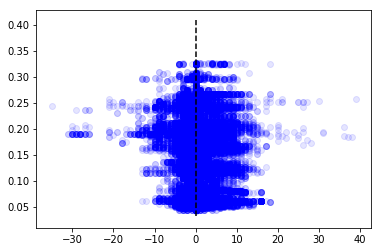

In [86]:
# plot everything
relative_date_var = 'relative_date'
dep_var = 'prob'
plt.scatter(anchor_data_NE_peak_filter_prob_data.loc[:, relative_date_var], anchor_data_NE_peak_filter_prob_data.loc[:, dep_var], c='b', alpha=0.1)
plt.vlines(0, anchor_data_NE_peak_filter_prob_data.loc[:, dep_var].min()*.75, anchor_data_NE_peak_filter_prob_data.loc[:, dep_var].max()*1.25, color='k', linestyles='--')
plt.show()

TODO: redo this with `seaborn` type confidence band? Or separate by data set? Yikes.

This looks awful! Let's simulate the curve instead using just the time coefficients and the average NE pre/post times for relative time.

time coefficients


Intercept         -0.865796
pre_peak          -0.300579
post_peak         -0.219148
since_post_peak   -0.028188
dtype: float64

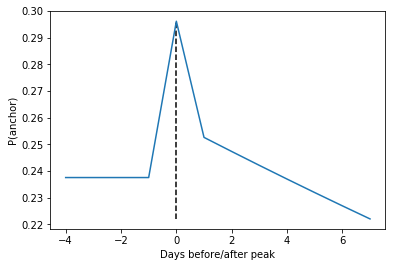

In [113]:
from math import floor, ceil
simulated_relative_time = np.arange(-1*int(floor(NE_pre_peak_mean)), int(ceil(NE_post_peak_mean)))
time_coeffs = model_res_full.params.loc[['Intercept', 'pre_peak', 'post_peak', 'since_post_peak']]
print('time coefficients')
display(time_coeffs)
# compute probability for each time
def compute_time_prob(x, time_coeffs, day_buffer=1):
    prob_weight = time_coeffs.loc['Intercept'] + time_coeffs.loc['pre_peak'] * (x <= -day_buffer).astype(int) + time_coeffs.loc['post_peak'] * (x >= day_buffer).astype(int) + time_coeffs.loc['since_post_peak']*(np.maximum(0, x - day_buffer))
    prob = 1 / (1 + np.exp(-1 * prob_weight))
    return prob
day_buffer = 1
probs = compute_time_prob(simulated_relative_time, time_coeffs, day_buffer=day_buffer)
plt.plot(simulated_relative_time, probs)
plt.vlines(0, probs.min(), probs.max(), linestyle='--')
plt.ylabel('P(anchor)')
plt.xlabel('Days before/after peak')
plt.show()

TODO: same thing but considering each data set separately? Overlapping lines etc.

### Investigate per-author effect
Let's look for a per-author effect with some interactions:

1. `C(author) * pre_peak`
2. `C(author) * post_peak`

We need to restrict this to authors who posted before and after the peak.

In [117]:
author_var = 'username'
pre_post_author_counts = anchor_data_NE_peak_filter.groupby(author_var).apply(lambda x: len(x.loc[:, 'post_peak'].value_counts()) > 1)
pre_post_authors = pre_post_author_counts[pre_post_author_counts].index
anchor_data_NE_peak_filter_pre_post_authors = anchor_data_NE_peak_filter[anchor_data_NE_peak_filter.loc[:, author_var].isin(pre_post_authors)]
print('%d/%d filtered'%(anchor_data_NE_peak_filter_pre_post_authors.shape[0], anchor_data_NE_peak_filter.shape[0]))

143421/145552 filtered


In [118]:
author_var = 'username'
NE_var = 'NE_fixed'
time_vars = ['pre_peak', 'post_peak', 'since_post_peak']
data_name_var = 'data_name_fixed'
dep_var = 'anchor'
time_author_var = 'C(%s)*%s'%(author_var, 'post_peak')
formula = '%s ~ C(%s) + C(%s) + C(%s) + %s + %s'%(dep_var, data_name_var, author_var, NE_var, ' + '.join(time_vars), time_author_var)
## fit full data with best hyperparam in terms of LL
l2_weight = 0.01
max_iter = 100
model_full = GLM.from_formula(formula, anchor_data_NE_peak_filter_pre_post_authors, family=Binomial(link=logit()))
model_res_full = model_full.fit_regularized(maxiter=max_iter, method='elastic_net', alpha=l2_weight, L1_wt=0.0)

In [119]:
model_err_data = compute_err_data(model_res_full)
display(model_err_data)

,mean,SE,z_score,p_val,conf_2.5,conf_97.5
Intercept,-0.870012,0.783980,-1.109738,0.218129,-2.406585,0.666560
C(data_name_fixed)[T.harvey],-0.504903,0.086749,-5.820274,0.000000,-0.674927,-0.334878
C(data_name_fixed)[T.irma],-0.624497,0.076335,-8.181021,0.000000,-0.774110,-0.474883
C(data_name_fixed)[T.maria],-0.222588,0.199752,-1.114322,0.214342,-0.614095,0.168919
C(data_name_fixed)[T.michael],0.049704,0.097801,0.508219,0.796186,-0.141981,0.241390
C(username)[T.10NewsWTSP],-0.001535,1.005727,-0.001526,0.999998,-1.972724,1.969653
C(username)[T.12NewsNow],-0.002025,1.105475,-0.001832,0.999997,-2.168716,2.164667
C(username)[T.247NewsHQ],0.010172,0.872003,0.011665,0.999891,-1.698924,1.719267
C(username)[T.4sh_4hm3d],0.001516,1.295350,0.001170,0.999999,-2.537324,2.540355
C(username)[T.5wa],-0.001919,1.079344,-0.001778,0.999997,-2.117394,2.113555


No clear effects here! We might need to do something less stupid.

### Test prior NE frequency
We see that the pre/post-peak variables have significant effects, but we can't be sure if this is a peak effect or a general post-high-frequency effect. Let's try to formalize this by computing prior NE frequency and using that as a predictor variable. We'll use $[t-1,t]$ as the time range for prior frequency.

In [140]:
from datetime import timedelta
def compute_NE_prior_freq(data, data_name_var='data_name_fixed', date_var='date_day', NE_var='NE_fixed', date_offset=1):
    date_offset_days = timedelta(days=date_offset)
    NE_freq = []
    for (name_i, date_i), data_i in data.groupby([data_name_var, date_var]):
        NE_counts_i = data_i.loc[:, NE_var].value_counts().reset_index().rename(columns={NE_var : 'NE_prior_freq', 'index' : NE_var})
        date_i_offset = date_i + date_offset_days
        NE_counts_i = NE_counts_i.assign(**{date_var : date_i_offset})
        NE_freq.append(NE_counts_i)
    NE_freq = pd.concat(NE_freq, axis=0)
    data_prior_freq = pd.merge(data, NE_freq, on=[date_var, NE_var], how='inner')
    return data_prior_freq

In [153]:
from sklearn.preprocessing import StandardScaler
anchor_data_NE_peak_filter_prior_freq = compute_NE_prior_freq(anchor_data_NE_peak_filter)
# log-scale, Z-norm
scaler = StandardScaler()
anchor_data_NE_peak_filter_prior_freq = anchor_data_NE_peak_filter_prior_freq.assign(**{'NE_prior_freq' : scaler.fit_transform(np.log(anchor_data_NE_peak_filter_prior_freq.loc[:, 'NE_prior_freq']).values.reshape(-1, 1))})

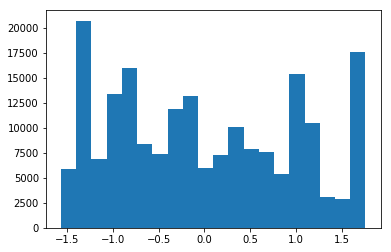

In [156]:
plt.hist(anchor_data_NE_peak_filter_prior_freq.loc[:, 'NE_prior_freq'], bins=20)
plt.show()

In [157]:
NE_freq_var = 'NE_prior_freq'
author_var = 'username'
NE_var = 'NE_fixed'
time_vars = ['pre_peak', 'post_peak', 'since_post_peak']
data_name_var = 'data_name_fixed'
dep_var = 'anchor'
formula = '%s ~ C(%s) + C(%s) + C(%s) + %s + %s'%(dep_var, data_name_var, author_var, NE_var, NE_freq_var, ' + '.join(time_vars))
## fit full data with best hyperparam in terms of LL
l2_weight = 0.01
max_iter = 100
model_full = GLM.from_formula(formula, anchor_data_NE_peak_filter_prior_freq, family=Binomial(link=logit()))
model_res_full = model_full.fit_regularized(maxiter=max_iter, method='elastic_net', alpha=l2_weight, L1_wt=0.0)

In [158]:
model_err_data = compute_err_data(model_res_full)
display(model_err_data)

,mean,SE,z_score,p_val,conf_2.5,conf_97.5
Intercept,-0.885775,0.559425,-1.583368,1.217420e-02,-1.982227,0.210677
C(data_name_fixed)[T.harvey],-0.503749,0.092640,-5.437679,0.000000e+00,-0.685321,-0.322177
C(data_name_fixed)[T.irma],-0.629855,0.083912,-7.506136,0.000000e+00,-0.794320,-0.465391
C(data_name_fixed)[T.maria],-0.163764,0.221794,-0.738363,5.856293e-01,-0.598472,0.270943
C(data_name_fixed)[T.michael],0.078868,0.107224,0.735547,5.884869e-01,-0.131287,0.289024
C(username)[T.10NewsWTSP],-0.001392,0.691377,-0.002013,9.999968e-01,-1.356465,1.353682
C(username)[T.11AliveNews],-0.000371,0.891136,-0.000417,9.999999e-01,-1.746966,1.746223
C(username)[T.12NewsNow],-0.001301,0.787557,-0.001652,9.999978e-01,-1.544885,1.542283
C(username)[T.1legalcom],-0.000502,1.107425,-0.000453,9.999998e-01,-2.171014,2.170010
C(username)[T.247NewsHQ],0.011267,0.616637,0.018272,9.997336e-01,-1.197319,1.219854


OK! As expected, higher prior frequency correlates with lower anchor use. 

Should we also throw in prior anchor use as an autoregressive feature? Might be going a bit too far.

### Robustness check: randomly permute peak times
What are the odds that the effects we observe are due to random chance? Let's randomly assign a peak time to each NE and re-run the regression to get a bootstrap sample of coefficients.

In [187]:
import numpy as np
from datetime import timedelta
def permute_peak_times(data, NE_var='NE_fixed', time_var='date_day', data_name_var='data_name_fixed', 
                       peak_date_var='NE_peak_date', date_buffer_days=1.):
    """
    Permute NE peak times in data.
    Draw each new peak time from uniform
    distribution over valid NE dates.
    
    :param data: post data
    :param NE_var: NE variable
    :param time_var: time variable
    :param data_name_var: data name variable
    :param peak_date_var: peak date variable
    :param date_buffer: buffer period length before/after peak date
    :returns data_permuted:: permuted post data
    """
    data_permuted = []
    date_buffer = timedelta(days=date_buffer_days)
    for (name_i, NE_i), data_i in data.groupby([NE_var, data_name_var]):
        NE_i_dates = data_i.loc[:, time_var].unique()
        peak_date_i = np.random.choice(NE_i_dates, 1)[0]
        data_i = data_i.assign(**{peak_date_var : [peak_date_i,]*data_i.shape[0]})
        data_permuted.append(data_i)
    data_permuted = pd.concat(data_permuted, axis=0)
    # recompute pre/post peak
    pre_peak_var = 'pre_peak'
    post_peak_var = 'post_peak'
    data_permuted = data_permuted.assign(**{
        pre_peak_var : data_permuted.loc[:, time_var] <= data_permuted.loc[:, peak_date_var] - date_buffer,
        post_peak_var : data_permuted.loc[:, time_var] >= data_permuted.loc[:, peak_date_var] + date_buffer,
    })
    return data_permuted

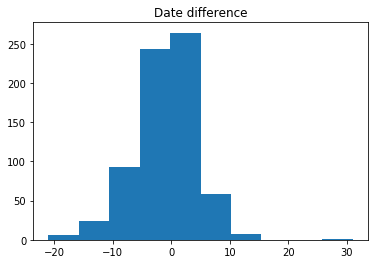

-1     71
 0     70
 1     62
 2     59
-2     50
-3     46
-4     40
 3     39
-5     36
 4     34
 5     30
-6     28
-7     21
-8     20
-9     16
 6     13
-10     8
-11     8
-12     7
 7      5
 8      5
-15     4
-16     3
-14     3
 14     3
 9      3
 11     2
-13     2
-21     2
 10     2
 31     1
 12     1
 13     1
-19     1
Name: date_diff, dtype: int64

In [188]:
np.random.seed(123)
# check distribution before permuting
peak_date_var = 'NE_peak_date'
NE_var = 'NE_fixed'
data_name_var = 'data_name_fixed'
pre_permute_peak_dates = anchor_data_NE_peak_filter.drop_duplicates([NE_var, data_name_var]).loc[:, [NE_var, data_name_var, peak_date_var]]
data_permuted = permute_peak_times(anchor_data_NE_peak_filter, peak_date_var=peak_date_var)
post_permute_peak_dates = data_permuted.drop_duplicates([NE_var, data_name_var]).loc[:, [NE_var, data_name_var, peak_date_var]]
post_permute_peak_dates.rename(columns={peak_date_var : 'permute_%s'%(peak_date_var)}, inplace=True)
# compute per-NE differences
permute_peak_dates = pd.merge(pre_permute_peak_dates, post_permute_peak_dates, on=[NE_var, data_name_var])
permute_peak_dates = permute_peak_dates.assign(**{'date_diff' : (permute_peak_dates.loc[:, peak_date_var] - permute_peak_dates.loc[:, 'permute_%s'%(peak_date_var)]).apply(lambda x: x.days)})
plt.hist(permute_peak_dates.loc[:, 'date_diff'])
plt.title('Date difference')
plt.show()
display(permute_peak_dates.loc[:, 'date_diff'].value_counts())

In [ ]:
np.random.seed(123)
# regression vars
author_var = 'username'
NE_var = 'NE_fixed'
time_vars = ['pre_peak', 'post_peak']
data_name_var = 'data_name_fixed'
dep_var = 'anchor'
formula = '%s ~ C(%s) + C(%s) + C(%s) + %s'%(dep_var, data_name_var, author_var, NE_var, ' + '.join(time_vars))
l2_weight = 0.01
max_iter = 100
# permute vars
peak_date_var = 'NE_peak_date'
# bootstrap params
bootstrap_iters = 50
bootstrap_coeffs = []
for b in range(bootstrap_iters):
    permute_data_b = permute_peak_times(anchor_data_NE_peak_filter, peak_date_var=peak_date_var, NE_var=NE_var, data_name_var=data_name_var)
    permute_data_b = permute_data_b.assign(**{
        v : permute_data_b.loc[:, v].astype(int)
        for v in time_vars
    })
    # fit model
    model_full = GLM.from_formula(formula, permute_data_b, family=Binomial(link=logit()))
    model_res_full = model_full.fit_regularized(maxiter=max_iter, method='elastic_net', alpha=l2_weight, L1_wt=0.0)
    # collect coefficients
    bootstrap_coeffs.append(model_res_full.params.loc[time_vars])
    if(b % 10 == 0):
        print('%d iters'%(b))
#         if(b >= 10):
#             break
bootstrap_coeffs = pd.concat(bootstrap_coeffs, axis=1).transpose()

0 iters
10 iters
20 iters


In [230]:
print(bootstrap_coeffs.mean(axis=0))
print(bootstrap_coeffs.std(axis=0))
# compute confidence intervals
conf_int_upper = bootstrap_coeffs.mean(axis=0) + bootstrap_coeffs.std(axis=0)*1.96
conf_int_lower = bootstrap_coeffs.mean(axis=0) - bootstrap_coeffs.std(axis=0)*1.96
bootstrap_conf_int = pd.concat([conf_int_upper, conf_int_lower], axis=1).rename(columns={0:'lower', 1:'upper'})
print(bootstrap_conf_int)
# sanity check
print(pd.concat([bootstrap_coeffs.apply(lambda x: np.percentile(x, 97.5), axis=0), bootstrap_coeffs.apply(lambda x: np.percentile(x, 2.5), axis=0)], axis=1).rename(columns={0:'lower', 1:'upper'}))

pre_peak    -0.293395
post_peak   -0.319058
dtype: float64
pre_peak     0.082882
post_peak    0.082201
dtype: float64
              lower     upper
pre_peak  -0.130947 -0.455843
post_peak -0.157945 -0.480172
              lower     upper
pre_peak  -0.153782 -0.424350
post_peak -0.201448 -0.486165


Overall it looks like the random permutation produces roughly equal coefficients, with a slight tendency toward higher anchor probability in `post_peak`.

Now let's plot the empirical and bootstrap probabilities side by side for a better comparison.

Re-fit model on full data.

In [222]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families.family import Binomial
from statsmodels.genmod.families.links import logit
author_var = 'username'
NE_var = 'NE_fixed'
time_vars = ['pre_peak', 'post_peak']
data_name_var = 'data_name_fixed'
dep_var = 'anchor'
formula = '%s ~ C(%s) + C(%s) + C(%s) + %s'%(dep_var, data_name_var, author_var, NE_var, ' + '.join(time_vars))
## fit full data with best hyperparam in terms of LL
l2_weight = 0.01
max_iter = 100
model_full = GLM.from_formula(formula, anchor_data_NE_peak_filter, family=Binomial(link=logit()))
model_res_full = model_full.fit_regularized(maxiter=max_iter, method='elastic_net', alpha=l2_weight, L1_wt=0.0)

In [223]:
## compute errors
model_err_data = compute_err_data(model_res_full)

In [224]:
model_err_data.loc[['pre_peak', 'post_peak'], :].head()

,mean,SE,z_score,p_val,conf_2.5,conf_97.5
pre_peak,-0.294669,0.02070,-14.235294,0.0,-0.335240,-0.254098
post_peak,-0.264036,0.01927,-13.702079,0.0,-0.301804,-0.226268


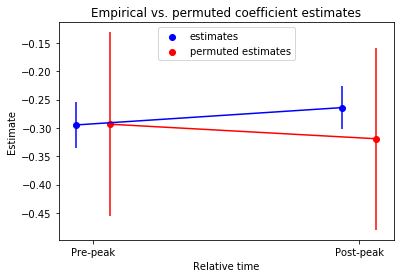

In [243]:
## plot CIs side by side
time_vars = ['pre_peak', 'post_peak']
time_vars_str = [x.capitalize().replace('_', '-') for x in time_vars]
X = np.arange(len(time_vars))
X_buffer = 0.0625
# real CIs
plt.scatter(X-X_buffer, model_err_data.loc[time_vars, 'mean'], label='estimates', color='b')
plt.scatter(X+X_buffer, bootstrap_coeffs.mean(axis=0), label='permuted estimates', color='r')
plt.errorbar(X-X_buffer, model_err_data.loc[time_vars, 'mean'], yerr=model_err_data.loc[time_vars, 'SE']*1.96, color='b', label=None)
plt.errorbar(X+X_buffer, bootstrap_coeffs.mean(axis=0), yerr=bootstrap_coeffs.std(axis=0)*1.96, color='r', label=None)
plt.xticks(X, time_vars_str)
plt.legend(loc='upper center')
plt.xlabel('Relative time')
plt.ylabel('Estimate')
plt.title('Empirical vs. permuted coefficient estimates')
plt.show()

## Aggregate per-author probability

Let's do a simpler test: for each author, find NEs that are mentioned before and after their peak. Then, compute P(anchor) for each NE before and after. Compute mean over all authors.

processing data=florence
1473/6539 after author filter
processed 20/229 authors
processed 40/229 authors
processed 60/229 authors
processed 80/229 authors
processed 100/229 authors
processed 120/229 authors
processed 140/229 authors
processed 160/229 authors
processed 180/229 authors
processed 200/229 authors
processed 220/229 authors
N prob=229
processing data=harvey
14894/67882 after author filter
processed 20/2019 authors
processed 40/2019 authors
processed 60/2019 authors
processed 80/2019 authors
processed 100/2019 authors
processed 120/2019 authors
processed 140/2019 authors
processed 160/2019 authors
processed 180/2019 authors
processed 200/2019 authors
processed 220/2019 authors
processed 240/2019 authors
processed 260/2019 authors
processed 280/2019 authors
processed 300/2019 authors
processed 320/2019 authors
processed 340/2019 authors
processed 360/2019 authors
processed 380/2019 authors
processed 400/2019 authors
processed 420/2019 authors
processed 440/2019 authors
process

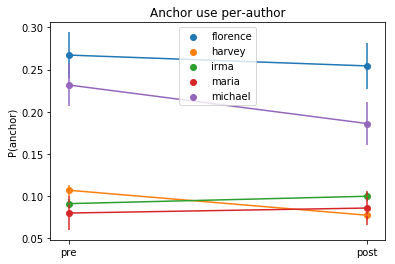

In [121]:
min_author_pre_count = 1
min_author_post_count = 1
min_pre_peak = 1
min_post_peak = 1
for name_i, data_i in anchor_data_NE_peak.groupby(data_name_var):
    print('processing data=%s'%(name_i))
    # restrict to consistent authors
    author_pre_counts_i = data_i[data_i.loc[:, 'pre_peak']==1].loc[:, author_var].value_counts()
    author_post_counts_i = data_i[data_i.loc[:, 'post_peak']==1].loc[:, author_var].value_counts()
    consistent_authors_i = list((author_pre_counts_i[author_pre_counts_i >= min_author_pre_count].index) & (author_post_counts_i[author_post_counts_i >= min_author_post_count].index))
#     consistent_authors_i = author_counts_i[author_counts_i >= min_author_count].index.tolist()
    data_i_consistent = data_i[data_i.loc[:, author_var].isin(consistent_authors_i)]
    print('%d/%d after author filter'%(data_i_consistent.shape[0], data_i.shape[0]))
    # simple start: unweighted mean
    author_NE_pre_peak_anchor_probs = []
    author_NE_post_peak_anchor_probs = []
    author_ctr = 0
    for author_j, data_i_j in data_i_consistent.groupby(author_var):
#         NE_pre_post_i_j = data_i_j.groupby(NE_var).apply(lambda x: (x.loc[:, 'pre_peak'].sum() >= min_pre_peak) & (x.loc[:, 'post_peak'].sum() >= min_post_peak))
#         NE_pre_post_i_j = NE_pre_post_i_j[NE_pre_post_i_j].index.tolist()
        NE_pre_post_i_j = data_i_j.loc[:, NE_var].unique()
#         if(len(NE_pre_post_i_j) == 0):
#             print('0 NEs pre/post for author %s'%(author_j))
        if(len(NE_pre_post_i_j) > 0):
            data_i_j = data_i_j[data_i_j.loc[:, NE_var].isin(NE_pre_post_i_j)]
#             pre_probs_i_j = data_i_j[data_i_j.loc[:, 'pre_peak']==1].groupby(NE_var).apply(lambda x: x.loc[:, anchor_var].mean())
#             post_probs_i_j = data_i_j[data_i_j.loc[:, 'post_peak']==1].groupby(NE_var).apply(lambda x: x.loc[:, anchor_var].mean())
            pre_prob_i_j = data_i_j[data_i_j.loc[:, 'pre_peak']==1].loc[:, anchor_var].mean()
            post_prob_i_j = data_i_j[data_i_j.loc[:, 'post_peak']==1].loc[:, anchor_var].mean()
            author_NE_pre_peak_anchor_probs.append(pre_prob_i_j)
            author_NE_post_peak_anchor_probs.append(post_prob_i_j)
#             author_NE_pre_peak_anchor_probs.append(np.mean(pre_probs_i_j))
#             author_NE_post_peak_anchor_probs.append(np.mean(post_probs_i_j))
    #         author_NE_pre_peak_anchor_probs += list(pre_probs_i_j.values)
    #         author_NE_post_peak_anchor_probs += list(post_probs_i_j.values)
        author_ctr += 1
        if(author_ctr % 20 == 0):
            print('processed %d/%d authors'%(author_ctr, len(consistent_authors_i)))
    # plot before/after
    print('N prob=%d'%(len(author_NE_pre_peak_anchor_probs)))
#     pre_prob_author_probs.append(author_NE_pre_peak_anchor_probs)
#     post_prob_author_probs.append(author_NE_post_peak_anchor_probs)
#     data_names.append(name_i)

## plot
    
    pre_prob_mean = np.mean(author_NE_pre_peak_anchor_probs)
    post_prob_mean = np.mean(author_NE_post_peak_anchor_probs)
    pre_prob_sd = np.std(author_NE_pre_peak_anchor_probs) / len(author_NE_pre_peak_anchor_probs)**.5
    post_prob_sd = np.std(author_NE_pre_peak_anchor_probs) / len(author_NE_pre_peak_anchor_probs)**.5
    plt.scatter([0,1], [pre_prob_mean, post_prob_mean], label=name_i)
    plt.errorbar([0,1], [pre_prob_mean, post_prob_mean], yerr=[pre_prob_sd, post_prob_sd])
plt.xticks([0,1], ['pre', 'post'])
# plt.title(name_i)
plt.ylabel('P(anchor)')
plt.legend(loc='upper center')
plt.title('Anchor use per-author')
plt.show()

### Look at authors with anchor increase/decrease

What is happening here? Let's look at the authors who decreased/increased their anchor use and the relevant tweet text.

In [122]:
min_author_pre_count = 2
min_author_post_count = 2
min_pre_peak = 1
min_post_peak = 1
min_author_NE_count = 5
author_anchor_data = []
for name_i, data_i in anchor_data.groupby(data_name_var):
    print('processing data=%s'%(name_i))
    # restrict to consistent authors
    author_pre_counts_i = data_i[data_i.loc[:, 'pre_peak']==1].loc[:, author_var].value_counts()
    author_post_counts_i = data_i[data_i.loc[:, 'post_peak']==1].loc[:, author_var].value_counts()
    consistent_authors_i = list((author_pre_counts_i[author_pre_counts_i >= min_author_pre_count].index) & (author_post_counts_i[author_post_counts_i >= min_author_post_count].index))
#     consistent_authors_i = author_counts_i[author_counts_i >= min_author_count].index.tolist()
    data_i_consistent = data_i[data_i.loc[:, author_var].isin(consistent_authors_i)]
    print('%d/%d after author filter'%(data_i_consistent.shape[0], data_i.shape[0]))
    # simple start: unweighted mean
    author_anchor_data_i = []
    txt = []
    author_ctr = 0
    for author_j, data_i_j in data_i_consistent.groupby(author_var):
#         NE_pre_post_i_j = data_i_j.groupby(NE_var).apply(lambda x: (x.loc[:, 'pre_peak'].sum() >= min_pre_peak) & (x.loc[:, 'post_peak'].sum() >= min_post_peak))
#         NE_pre_post_i_j = NE_pre_post_i_j[NE_pre_post_i_j].index.tolist()
        NE_pre_post_i_j = data_i_j.loc[:, NE_var].unique()
#         if(len(NE_pre_post_i_j) == 0):
#             print('0 NEs pre/post for author %s'%(author_j))
        if(len(NE_pre_post_i_j) > 0):
            data_i_j = data_i_j[data_i_j.loc[:, NE_var].isin(NE_pre_post_i_j)]
            data_i_j_pre = data_i_j[data_i_j.loc[:, 'pre_peak']==1]
            data_i_j_post = data_i_j[data_i_j.loc[:, 'post_peak']==1]
#             pre_probs_i_j = data_i_j[data_i_j.loc[:, 'pre_peak']==1].groupby(NE_var).apply(lambda x: x.loc[:, anchor_var].mean())
#             post_probs_i_j = data_i_j[data_i_j.loc[:, 'post_peak']==1].groupby(NE_var).apply(lambda x: x.loc[:, anchor_var].mean())
            pre_prob_i_j = data_i_j_pre.loc[:, anchor_var].mean()
            post_prob_i_j = data_i_j_post.loc[:, anchor_var].mean()
            prob_diff_i_j = post_prob_i_j - pre_prob_i_j
#             pre_txt = data_i_j[data_i_j.loc[:, 'pre_peak']==1]
            N_i_j = data_i_j.shape[0]
            pre_txt_i_j = list(data_i_j_pre.loc[:, 'txt'].values)
            post_txt_i_j = list(data_i_j_post.loc[:, 'txt'].values)
            author_anchor_data_i.append([pre_prob_i_j, post_prob_i_j, prob_diff_i_j, N_i_j, author_j, pre_txt_i_j, post_txt_i_j])
#             author_NE_pre_peak_anchor_probs.append(np.mean(pre_probs_i_j))
#             author_NE_post_peak_anchor_probs.append(np.mean(post_probs_i_j))
    #         author_NE_pre_peak_anchor_probs += list(pre_probs_i_j.values)
    #         author_NE_post_peak_anchor_probs += list(post_probs_i_j.values)
        author_ctr += 1
        if(author_ctr % 20 == 0):
            print('processed %d/%d authors'%(author_ctr, len(consistent_authors_i)))
    author_anchor_data_i = pd.DataFrame(author_anchor_data_i, columns=['pre_prob', 'post_prob', 'post_pre_prob_diff', 'NE_count', 'username', 'pre_peak_txt', 'post_peak_txt'])
    author_anchor_data_i = author_anchor_data_i.assign(**{'data_name' : name_i})
    # restrict to more frequently posting authors
    author_anchor_data_i = author_anchor_data_i[author_anchor_data_i.loc[:, 'NE_count'] >= min_author_NE_count]
    author_anchor_data.append(author_anchor_data_i)
author_anchor_data = pd.concat(author_anchor_data, axis=0)

processing data=florence
1181/9021 after author filter
processed 20/95 authors
processed 40/95 authors
processed 60/95 authors
processed 80/95 authors
processing data=harvey
4241/72992 after author filter
processed 20/234 authors
processed 40/234 authors
processed 60/234 authors
processed 80/234 authors
processed 100/234 authors
processed 120/234 authors
processed 140/234 authors
processed 160/234 authors
processed 180/234 authors
processed 200/234 authors
processed 220/234 authors
processing data=irma
12347/66143 after author filter
processed 20/789 authors
processed 40/789 authors
processed 60/789 authors
processed 80/789 authors
processed 100/789 authors
processed 120/789 authors
processed 140/789 authors
processed 160/789 authors
processed 180/789 authors
processed 200/789 authors
processed 220/789 authors
processed 240/789 authors
processed 260/789 authors
processed 280/789 authors
processed 300/789 authors
processed 320/789 authors
processed 340/789 authors
processed 360/789 auth

Plot overall differences first, then per-dataset differences.

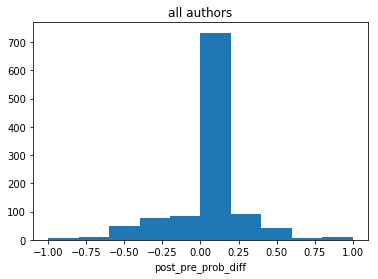

significant diff (mean=0.011) with test_stat=68076.000 (p=9.923E-02)


In [123]:
from importlib import reload
import scipy
reload(scipy)
from scipy.stats import wilcoxon
# plot distribution of probability difference
plt.hist(author_anchor_data.loc[:, 'post_pre_prob_diff'], bins=10)
plt.xlabel('post_pre_prob_diff')
plt.title('all authors')
plt.show()
## test whether post/pre are from same distribution
test_stat, p_val = wilcoxon(author_anchor_data.loc[:, 'post_pre_prob_diff'].values)
print('significant diff (mean=%.3f) with test_stat=%.3f (p=%.3E)'%(author_anchor_data.loc[:, 'post_pre_prob_diff'].mean(), test_stat, p_val))

testing data florence


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
29,0.000000,1.0,1.000000,6,JVPStorm,"[Slowly but surely, #Florence is coming. We’re...","[Water, water everywhere. The Lumber river is ...",florence
35,0.416667,1.0,0.583333,14,MarkProkop2,"[On @GetSpectrum News now. Cumberland County, ...",[Picked up my free bagel and cream cheese from...,florence
38,0.000000,0.5,0.500000,5,MollyGrantham,[An easy Charlotte shelter now at capacity wit...,[Think #Florence is over? Not for some Carolin...,florence
90,0.000000,0.5,0.500000,6,uscgmidatlantic,"[#USCG shallow-water teams, partner agencies r...",[#USCG crews combined forces with the @USArmy ...,florence
12,0.000000,0.5,0.500000,6,CarolineHicksTV,[Myers Park in CLT is lined with 100+ yr old t...,[This morning two teams deployed from the @Low...,florence


array([['JVPStorm',
        list(['Slowly but surely, #Florence is coming. We’re on top of it on@WeatherNation @9Cowboysruleand are in Morehead City looking across to Atlantic Beach. Beach access ended at 7am Eastern. <URL>', 'Slowly but surely, #Florence is coming. We’re on top of it on@WeatherNation @9Cowboysruleand are in Morehead City looking across to Atlantic Beach. Beach access ended at 7am Eastern. <URL>', '86mph gust in Morehead City! #Florence coverage continues on @WeatherNation WAIT just got 90. With @9Cowboysrule <URL>', 'Sad to see this damage in Morehead City. There’ll be much more to see when the sun comes up. We have you covered through the night on @WeatherNation #Florence <URL>']),
        list(['Water, water everywhere. The Lumber river is flooding parts of Lumberton, NC in the wake of record rain from #florence. We have updates this afternoon on @WeatherNation. #NCWX <URL>', 'More neighborhoods are under water in Bucksport, SC. @WeatherNation has more updates on th

,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
41,1.000000,0.400000,-0.600000,10,NancyMcG91,[Boarding up #Florence on her way. Hanging out...,"[Thank you, from Wilmington. #FlorenceNC @Fox...",florence
52,0.750000,0.111111,-0.638889,14,SCNationalGuard,"[#NationalGuard SSG Chris Wuerzberger, from th...",[#SCGuard Engineer Soldiers w/125th Multi-Role...,florence
80,0.666667,0.000000,-0.666667,8,myFayToday,[Fayetteville ... Today #HurricaneFlorence d...,[WANNA DONATE? TRY HERE UPDATED DONATIONS LIST...,florence
13,0.750000,0.000000,-0.750000,11,ChrisJacksonSC,[Right now the Lumber River is pretty tranquil...,[I’m glad I went through Nichols last Thursday...,florence
84,1.000000,0.000000,-1.000000,7,pirateradio1250,[Wow! Here is a before and after picture of Ne...,"[HOT READ: After fleeing Hurricane #Florence ,...",florence


array([['NancyMcG91',
        list(['Boarding up #Florence on her way. Hanging out beerbellies109 downtown. @ Wilmington, North Carolina <URL>', 'Good morning from Wilmington.#Florence @ Wilmington, North Carolina <URL>', 'Good morning from Wilmington.#Florence @ Wilmington, North Carolina <URL>', 'Good morning from Wilmington.#Florence @ Wilmington, North Carolina <URL>', 'Good morning from Wilmington.#Florence @ Wilmington, North Carolina <URL>']),
        list(['Thank you, from Wilmington.  #FlorenceNC @FoxWilmington', '@charleskrugwine so I joined the @charleskrugwine club after visiting the winery during my wonderful @winetrain experience and my first shipment made it as far as Raleigh before @UPS sent it back to Napa. Missing my wine here in Wilmington #HurricaneFlorence', '@charleskrugwine so I joined the @charleskrugwine club after visiting the winery during my wonderful @winetrain experience and my first shipment made it as far as Raleigh before @UPS sent it back to Napa. Miss

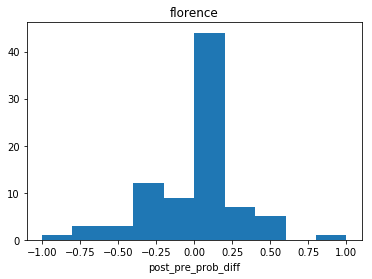

significant diff (median=0.000) with test_stat=528.500 (p=4.031E-01)
testing data harvey


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
232,0.0,1.000000,1.000000,10,wxjerdman,[Other #Harvey impacts: Long-lived coastal #fl...,"[Still 6-7' surge levels at Port Lavaca, TX. G...",harvey
6,0.0,0.666667,0.666667,5,AmandaNicole047,[#HurricaneHarvey now officially category 3. T...,[My high school in La Porte. 15 mins away from...,harvey
159,0.0,0.500000,0.500000,9,Yubbie007,[Coldplay Concert is still tomorrow in Houston...,[The left is a Houston freeway on Saturday. Th...,harvey
114,0.0,0.500000,0.500000,7,MingoMariano,[It appears that #Harvey may be heading to Hou...,"[Current road closures in San Antonio, Texas. ...",harvey
116,0.0,0.500000,0.500000,7,NEweatherHQ,[Since weather across the Northeast will be ca...,"[Live Local Houston, Texas News: <URL>, More I...",harvey


array([['wxjerdman',
        list(["Other #Harvey impacts: Long-lived coastal #flooding E of center won't allow flooded rivers/bayous to drain. <URL>", 'Ens. mean model trend: Heavier rain farther E in southeast LA (Baton Rouge, N. Orleans), southern MS, south AL, maybe FL panhandle. #Harvey <URL>']),
        list(["Still 6-7' surge levels at Port Lavaca, TX. Given #Harvey stall, elevated tide levels to persist for several days, slowly falling. <URL>", "Brazos River at Richmond, TX to crest over 4' above previous record set just last June. Mandatory evacs: <URL>", 'Rain rates generally 1/2 - 3/4" per hour in southeast Harris Co. Prolific rainfall rates (5"/hour est\'d) in Jefferson County, TX. #Harvey <URL>', 'Within an earshot of all-time U.S. #tropical cyclone rain record since 1950 (48" in Medina, TX from Amelia 1978, per @DRmetwatch ). #Harvey <URL>', "Unbelievable. Beaumont/Port Arthur, TX more than 2x'd their previous calendar-day and 4-day storm-total rainfall record. #Harvey <U

,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
107,0.750000,0.111111,-0.638889,13,LaytenHolland,[The NWS has issued a Storm Surge Watch from P...,[Major flooding of the Buffalo Bayou expected ...,harvey
205,0.666667,0.000000,-0.666667,7,nsg794,"[I would advise not going to Corpus Christi, V...","[I've been seeing a lot of ""Pray for Houston"" ...",harvey
49,0.666667,0.000000,-0.666667,19,Doc_Sanger,[NHC finally seeing it my way forecasting #Har...,[New NHC track shows #Harvey meandering throug...,harvey
103,1.000000,0.000000,-1.000000,7,Kristine_Galvan,"[Flashback: Galveston, Texas one day before Hu...",[#TexasStrong #HurricaneHarvey #LLWS Lets Go L...,harvey
170,1.000000,0.000000,-1.000000,8,christyvourcos,[Will @NBCNightShift be on tonight in Corpus C...,[Thank you to all who have helped with #Harvey...,harvey


array([['LaytenHolland',
        list(['The NWS has issued a Storm Surge Watch from Port Mansfield to High Island, TX. Think about protecting property from likely flooding #Harvey <URL>', 'Mandatory evacuations in relation to #Harvey for Metagorda, Brazoria, Galveston and Chambers, TX. Stay safe and evacuate. <URL>', 'Mandatory evacuations in relation to #Harvey for Metagorda, Brazoria, Galveston and Chambers, TX. Stay safe and evacuate. <URL>', 'Mandatory evacuations in relation to #Harvey for Metagorda, Brazoria, Galveston and Chambers, TX. Stay safe and evacuate. <URL>']),
        list(['Major flooding of the Buffalo Bayou expected as a result of #Harvey . Image credit: @NWSCentral #houstonflood . Stay alert Houston <URL>', 'Near record flooding of the Brazos River near Rosharon expected as a result of #Harvey . Image Credit @NWSCentral #houstonflood <URL>', 'Record flooding of the Cyprus Creek near Westfield expected as a result of #Harvey . Image Credit @NWSCentral #houstonflood <

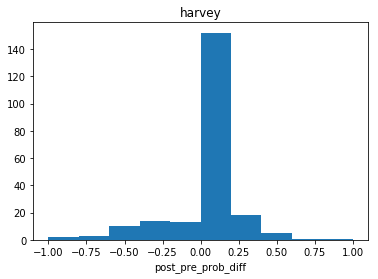

significant diff (median=0.000) with test_stat=2952.500 (p=5.391E-01)
testing data irma


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
128,0.0,1.0,1.0,11,DanEBoy09,[Publix on Jog and Linton in Delray Beach. #Hu...,"[Winds really picking up here in Delray Beach,...",irma
755,0.0,1.0,1.0,5,tornadotrackers,[The NAM 12z run takes #Irma from Everglades l...,[Strong couplet that approached Indialantic an...,irma
345,0.0,1.0,1.0,5,NEWeatherWx,[Big changes on the GFS. EURO looks very simil...,[Hurricane #Irma Alerts; TS Watch Issued In At...,irma
25,0.0,1.0,1.0,8,AdrianWVTM13,[The eye of powerful Category 5 #HurricaneIrma...,"[The eyewall, containing 100+ mph sustained wi...",irma
151,0.0,1.0,1.0,8,DrLindaShelton,[Miami must evacuate #Irma #GOP #p2 #millenial...,[#Irma in Miami flooding #p2 #millenials #vete...,irma


array([['DanEBoy09',
        list(['Publix on Jog and Linton in Delray Beach. #HurricaneIrma #prep #delraybeach . Traffic in the store was worse than the day before Thanksgiving <URL>', 'Publix on Jog and Linton in Delray Beach. #HurricaneIrma #prep #delraybeach . Traffic in the store was worse than the day before Thanksgiving <URL>']),
        list(['Winds really picking up here in Delray Beach, FL. #hurricane #irma #delraybeach #florida . <URL>', 'Really starting to get wild here in Delray Beach, FL. #hurricane #irma #HurricaneIrma <URL>', 'Another huge gust to at least 62 mph here in Delray Beach, FL! #hurricane #Irma #delraybeach #florida #flwx @LoleskyWX <URL>', 'Irma is getting fierce here in Delray Beach, FL! #hurricane #irma #delraybeach #florida . <URL>', 'Irma is cranking!!! 80 to 90 mph gusts!!! Delray Beach, FL #hurricane #irma #delraybeach #florida . <URL>', 'Lots of tree damage in the Delray Beach, Florida area. #hurricane #irma #delraybeach #florida #flwx <URL>', 'More h

,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
599,0.666667,0.000000,-0.666667,6,erluko,[About this long before Andrew hit in '92 I wa...,[Friend of @B_Kobrin reports A1A in Ft. Lauder...,irma
328,0.666667,0.000000,-0.666667,5,MikeLaPointWX,[Right now the spaghetti models have #hurrican...,[We are seeing the high clouds from Irma right...,irma
687,1.000000,0.333333,-0.666667,5,najafawan786,[RT : hoping I could get water but every time ...,[Its so sad to see Irma destroying Florida tha...,irma
186,0.833333,0.000000,-0.833333,8,FreightCenter,[Service Alerts: We are already showing signs ...,[Freight embargo still in place for Fort Myers...,irma
197,1.000000,0.142857,-0.857143,9,Graybar,"[Hurricane Update: Locations in Savannah, GA &...",[ATTN Atlanta customers: Our locations in Norc...,irma


array([['erluko',
        list(["About this long before Andrew hit in '92 I was on a greyhound home to Miami from NYC. Now I'm boarding a flight to Florida from DC. #irma", "Winnsboro, SC has one hotel room left? Not any more. 4hrs from bed. Never heard of Winnsboro before. Hope it's nice. #irma", 'Safe and sound from #irma in Winnsboro, SC.']),
        list(['Friend of @B_Kobrin reports A1A in Ft. Lauderdale remains covered in sand from #Irma .', 'Broward County Public Schools offering free hot lunch on 9/15 in support of families w/out electricity due to #irma info: 754-321-0321', 'I took a walk along the New River on the Friday after #Irma . Cleanup had progressed very well. <URL>'])],
       ['MikeLaPointWX',
        list(['Right now the spaghetti models have #hurricaneirma heading toward Savannah, GA and Hilton Head Island, SC by Monday afternoon/evening. #kwkt <URL>', 'Right now the spaghetti models have #hurricaneirma heading toward Savannah, GA and Hilton Head Island, SC by Mon

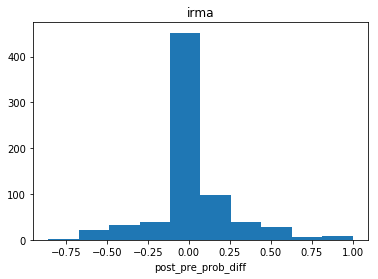

significant diff (median=0.000) with test_stat=22719.000 (p=4.085E-04)
testing data maria


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
29,0.000000,0.333333,0.333333,5,pearlsNparis_xo,"[The current photos of Loíza, San Isidro & Toa...",[BUT what about all the towns not near San Jua...,maria
9,0.083333,0.333333,0.250000,28,LawrenceCOEM,[QuakesToday: 2.0 magnitude #earthquake . 5 km...,[dhs_jules: RT chefjoseandres: Quick report fr...,maria
16,0.000000,0.200000,0.200000,18,USCGSoutheast,"[#BreakingNews @USCG , @USNavy , @RoyalNavy se...",[The #USCG delievers fuel and water to Vieques...,maria
32,0.666667,0.750000,0.083333,8,torrea40,"[This is a line for gas in San Juan, Puerto Ri...","[The #USCG delivers 28,000 lbs of supplies in ...",maria
14,1.000000,1.000000,0.000000,36,RelaxInPR,"[In San Juan, PR Partly Cloudy today! With a h...","[In San Juan, PR PM Showers today! With a high...",maria


array([['pearlsNparis_xo',
        list(['The current photos of Loíza, San Isidro & Toa baja are heartbreaking! The rebuild needed will be massive #HurricaneMaria #PuertoRico <URL>', 'The current photos of Loíza, San Isidro & Toa baja are heartbreaking! The rebuild needed will be massive #HurricaneMaria #PuertoRico <URL>']),
        list(['BUT what about all the towns not near San Juan?? #HurricaneMaria #PuertoRico <URL>', 'Our potus is in Guaynabo -one of the wealthiest towns in Puerto Rico - does anyone know if he plans to go out of San Juan?? #hurricanemaria', 'Our potus is in Guaynabo -one of the wealthiest towns in Puerto Rico - does anyone know if he plans to go out of San Juan?? #hurricanemaria'])],
       ['LawrenceCOEM',
        list(['QuakesToday: 2.0 magnitude #earthquake . 5 km from Pole Ojea, Cabo Rojo, #PuertoRico <URL>', 'QuakesToday: 2.3 magnitude #earthquake . 77 km from Culebra, Culebra, #PuertoRico <URL>', 'QuakesToday: 2.0 magnitude #earthquake . 4 km from Puerto Re

,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
0,0.333333,0.0,-0.333333,11,9ablo,"[Streets of Old San Juan, known for their rich...",[. @POTUS lands PR at 11:45am and will be welc...,maria
30,0.833333,0.5,-0.333333,9,puertoricobuzz,[Current situation in #HatoRey during the unio...,"[This temp shelter in Vega Baja, Puerto Rico, ...",maria
20,1.000000,0.5,-0.500000,8,femaregion2,"[9/19 — A boarded-up restaurant in San Juan, P...","[10/5, #PRStrong : @salvationarmy delivered ho...",maria
17,0.500000,0.0,-0.500000,7,UnivisionPR,[Desesperación entre los residentes de Bayamón...,"[Desolados, los habitantes de Vieques claman p...",maria
2,0.500000,0.0,-0.500000,6,CharlesSimmins,[Rumors from PR that union truck drivers are r...,[All FEMA aid has been transported from the co...,maria


array([['9ablo',
        list(['Streets of Old San Juan, known for their rich tourism, are deserted 24hrs before cat 5 #HurricaneMaria reaches Puerto Rico. @thedailybeast <URL>', 'Damages #HurricaneMaria caused in Arecibo, Puerto Rico Pt2. <URL>', 'Damages #HurricaneMaria caused in Arecibo, Puerto Rico Pt4. <URL>', 'Damages #HurricaneMaria caused in Arecibo, Puerto Rico Pt5. <URL>', '#HurricaneMaria death toll in Puerto Rico rises to 16. Last 6 were in: Río Grande, Jayuya, Aguadilla and Hormigueros, says @SecAsuntosPR', '#HurricaneMaria death toll in Puerto Rico rises to 16. Last 6 were in: Río Grande, Jayuya, Aguadilla and Hormigueros, says @SecAsuntosPR', '#HurricaneMaria death toll in Puerto Rico rises to 16. Last 6 were in: Río Grande, Jayuya, Aguadilla and Hormigueros, says @SecAsuntosPR', '. @Nycoem personal have been deployed in San Juan to work with @CarmenYulinCruz #HurricaneMaria <URL>', "#HurricaneMaria 's force: A giant buoy often used by cargo ships to navigate at sea is f

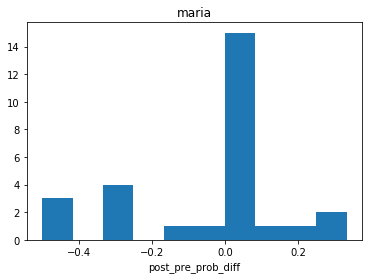

significant diff (median=0.000) with test_stat=18.500 (p=5.809E-02)
testing data michael


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
28,0.500000,1.000000,0.500000,7,ReedTimmerAccu,[MEXICO BEACH total devastation from big-time ...,"[Mexico Beach, FL storm surge aftermath from h...",michael
17,0.000000,0.333333,0.333333,5,JoshFitzWx,"[Erie sound from the hurricane #Michael!, 'Cha...",[#Michael lays bare Panhandle's weaker buildin...,michael
15,0.090909,0.416667,0.325758,24,HumanityRoad,"[#FL #HurricaneMichael """"Closed state offices ...",[#FL #MexicoBeach “Members of the Urban Search...,michael
11,0.000000,0.222222,0.222222,15,DukeEnergy,"[More than 80% of our customers in Bay, Frankl...","[Crews arrived in Port St. Joe, Fla., to assis...",michael
2,0.000000,0.166667,0.166667,9,BCWildfireToday,"[""""The worst of Tropical Storm Michael came be...","[#GulfCounty , #Florida BOIL WATER ADVISORY IN...",michael


array([['ReedTimmerAccu',
        list(['MEXICO BEACH total devastation from big-time storm surge and wind with brunt of Hurricane #Michael right eye wall. 24 hours after impact. Very long road of recovery ahead but search and rescue mode continues. Continued coverage for @accuweather <URL>', 'Video: Homes swept of foundation or missing from their stilt foundation in Mexico Beach, FL; scenes of complete destruction up and down the beach. This was where the brunt of Hurricane #Michael storm surge came ashore @breakingweather @accuweather <URL>']),
        list(["Mexico Beach, FL storm surge aftermath from helicopter 48 hours after Hurricane #Michael landfall. This is why you don't stay near the beach when a category 4 hurricane is coming ashore. @accuweather <URL>", 'Video: closer look at U.S. Coast Guard chopper on scene the day after Hurricane #Michael landfall on the runway in Apalachicola, FL; interview with a rescue swimmer @accuweather <URL>'])],
       ['JoshFitzWx',
        list

,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
59,0.833333,0.333333,-0.500000,9,wxkaylee13,[#HurricaneMichael made landfall at 12:30pm CT...,[Oh wow! A water tower was taken down in Mexic...,michael
27,0.666667,0.040000,-0.626667,29,ReadCarlos,[Prayers for those in harms way as Category 4 ...,[Covering #HurricaneMichael ... please contact...,michael
10,0.666667,0.000000,-0.666667,10,DrRickKnabb,"[Sadly, we now have 6 confirmed fatalities due...",[So sad to learn that one fatality has been co...,michael
8,0.857143,0.000000,-0.857143,9,CharlesPDavis,"[Damage from #HurricaneMichael in Panama City,...",[#Repost @abc ・・・ A gas station in Panama City...,michael
42,1.000000,0.000000,-1.000000,8,WVTM13,[#HurricaneMichael: Driving around in Panama C...,[Panama City couple flees to Birmingham for bi...,michael


array([['wxkaylee13',
        list(['#HurricaneMichael made landfall at 12:30pm CT between Tyndall AFB and Mexico Beach, FL, but Mexico Beach got the worst of it because it was in the right upper hand quadrant once you slice the hurricane in a vertical and horizontal pattern through the eye that’s how you know it’s <URL>', '#HurricaneMichael made landfall at 12:30pm CT between Tyndall AFB and Mexico Beach, FL, but Mexico Beach got the worst of it because it was in the right upper hand quadrant once you slice the hurricane in a vertical and horizontal pattern through the eye that’s how you know it’s <URL>', '#HurricaneMichael made landfall at 12:30pm CT between Tyndall AFB and Mexico Beach, FL, but Mexico Beach got the worst of it because it was in the right upper hand quadrant once you slice the hurricane in a vertical and horizontal pattern through the eye that’s how you know it’s <URL>', '#HurricaneMichael made landfall at 12:30pm CT between Tyndall AFB and Mexico Beach, FL, but Mexi

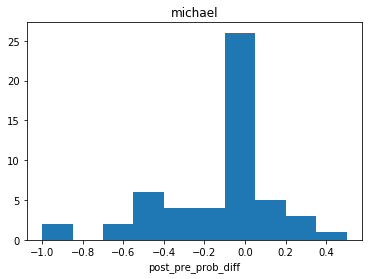

significant diff (median=0.000) with test_stat=87.000 (p=4.731E-03)


In [124]:
from scipy.stats import wilcoxon
top_k = 5
for name_i, data_i in author_anchor_data.groupby('data_name'):
    print('testing data %s'%(name_i))
    data_i.sort_values('post_pre_prob_diff', inplace=True, ascending=False)
    display(data_i.head(top_k))
    display(data_i.head(top_k).loc[:, ['username', 'pre_peak_txt', 'post_peak_txt']].values)
    display(data_i.tail(top_k))
    display(data_i.tail(top_k).loc[:, ['username', 'pre_peak_txt', 'post_peak_txt']].values)
    # plot distribution of probability difference
    plt.hist(data_i.loc[:, 'post_pre_prob_diff'], bins=10)
    plt.xlabel('post_pre_prob_diff')
    plt.title(name_i)
    plt.show()
    ## test whether post/pre are from same distribution
    test_stat, p_val = wilcoxon(data_i.loc[:, 'post_pre_prob_diff'].values)
    print('significant diff (median=%.3f) with test_stat=%.3f (p=%.3E)'%(data_i.loc[:, 'post_pre_prob_diff'].median(), test_stat, p_val))

- Possible reason for increase in anchoring: people initially discussing one/a few locations then post-peak discussing wider range of locations that require more anchors for (same) audience.
    - `irma`, user=`tornadotrackers`, pre="The NAM 12z run takes #Irma from Everglades landfall, giving Miami the right side of eye, then right up the belly of #Florida (over Orlando)", post="Strong couplet that approached Indialantic and Melbourne, FL associated with one of #Irma ’s many feeder bands. #flwx"
- Possible reason for decrease in anchoring: people consistently discussing local locations or more popular locations post-peak? Ex. switch from "Wilmington, NC" to "Wilmington".
    - `harvey`, user=`PamyDFoley`, pre="I live in Rockport, Texas", post="Please pray for Rockport" => pre-hurricane signalling, post-hurricane sympathy

Can we subset this to just the authors who mention the same location pre/post peak?

In [125]:
min_author_pre_count = 2
min_author_post_count = 2
min_pre_peak = 1
min_post_peak = 1
min_author_NE_count = 5
author_anchor_data = []
for name_i, data_i in anchor_data.groupby(data_name_var):
    print('processing data=%s'%(name_i))
    # restrict to consistent authors
    author_pre_counts_i = data_i[data_i.loc[:, 'pre_peak']==1].loc[:, author_var].value_counts()
    author_post_counts_i = data_i[data_i.loc[:, 'post_peak']==1].loc[:, author_var].value_counts()
    consistent_authors_i = list((author_pre_counts_i[author_pre_counts_i >= min_author_pre_count].index) & (author_post_counts_i[author_post_counts_i >= min_author_post_count].index))
#     consistent_authors_i = author_counts_i[author_counts_i >= min_author_count].index.tolist()
    data_i_consistent = data_i[data_i.loc[:, author_var].isin(consistent_authors_i)]
    print('%d/%d after author filter'%(data_i_consistent.shape[0], data_i.shape[0]))
    # simple start: unweighted mean
    author_anchor_data_i = []
    txt = []
    author_ctr = 0
    for author_j, data_i_j in data_i_consistent.groupby(author_var):
        NE_pre_post_i_j = data_i_j.loc[:, NE_var].unique()
        if(len(NE_pre_post_i_j) > 0):
            data_i_j = data_i_j[data_i_j.loc[:, NE_var].isin(NE_pre_post_i_j)]
            data_i_j_pre = data_i_j[data_i_j.loc[:, 'pre_peak']==1]
            data_i_j_post = data_i_j[data_i_j.loc[:, 'post_peak']==1]
            pre_post_NE_i_j = set(data_i_j_pre.loc[:, 'NE_fixed'].unique()) & set(data_i_j_post.loc[:, 'NE_fixed'].unique())
            if(len(pre_post_NE_i_j) > 0):
                data_i_j = data_i_j[data_i_j.loc[:, 'NE_fixed'].isin(pre_post_NE_i_j)]
                data_i_j_pre = data_i_j[data_i_j.loc[:, 'pre_peak']==1]
                data_i_j_post = data_i_j[data_i_j.loc[:, 'post_peak']==1]
                pre_prob_i_j = data_i_j_pre.loc[:, anchor_var].mean()
                post_prob_i_j = data_i_j_post.loc[:, anchor_var].mean()
                prob_diff_i_j = post_prob_i_j - pre_prob_i_j
                N_i_j = data_i_j.shape[0]
                pre_txt_i_j = list(data_i_j_pre.loc[:, 'txt'].values)
                post_txt_i_j = list(data_i_j_post.loc[:, 'txt'].values)
                author_anchor_data_i.append([pre_prob_i_j, post_prob_i_j, prob_diff_i_j, N_i_j, author_j, pre_txt_i_j, post_txt_i_j])
#             author_NE_pre_peak_anchor_probs.append(np.mean(pre_probs_i_j))
#             author_NE_post_peak_anchor_probs.append(np.mean(post_probs_i_j))
    #         author_NE_pre_peak_anchor_probs += list(pre_probs_i_j.values)
    #         author_NE_post_peak_anchor_probs += list(post_probs_i_j.values)
        author_ctr += 1
        if(author_ctr % 20 == 0):
            print('processed %d/%d authors'%(author_ctr, len(consistent_authors_i)))
    author_anchor_data_i = pd.DataFrame(author_anchor_data_i, columns=['pre_prob', 'post_prob', 'post_pre_prob_diff', 'NE_count', 'username', 'pre_peak_txt', 'post_peak_txt'])
    author_anchor_data_i = author_anchor_data_i.assign(**{'data_name' : name_i})
    # restrict to more frequently posting authors
    author_anchor_data_i = author_anchor_data_i[author_anchor_data_i.loc[:, 'NE_count'] >= min_author_NE_count]
    author_anchor_data.append(author_anchor_data_i)
author_anchor_data = pd.concat(author_anchor_data, axis=0)

processing data=florence
1181/9021 after author filter
processed 20/95 authors
processed 40/95 authors
processed 60/95 authors
processed 80/95 authors
processing data=harvey
4241/72992 after author filter
processed 20/234 authors
processed 40/234 authors
processed 60/234 authors
processed 80/234 authors
processed 100/234 authors
processed 120/234 authors
processed 140/234 authors
processed 160/234 authors
processed 180/234 authors
processed 200/234 authors
processed 220/234 authors
processing data=irma
12347/66143 after author filter
processed 20/789 authors
processed 40/789 authors
processed 60/789 authors
processed 80/789 authors
processed 100/789 authors
processed 120/789 authors
processed 140/789 authors
processed 160/789 authors
processed 180/789 authors
processed 200/789 authors
processed 220/789 authors
processed 240/789 authors
processed 260/789 authors
processed 280/789 authors
processed 300/789 authors
processed 320/789 authors
processed 340/789 authors
processed 360/789 auth

testing data florence


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
27,0.500000,1.000000,0.500000,6,ZacharysWeather,[RT TevinWooten: Getting a look at neighborhoo...,[The Lumber River overflows onto a stretch Int...,florence
23,0.000000,0.333333,0.333333,5,USACEHQ,[Personnel receive large sandbags and other su...,[U.S. Army Corps of Engineers logistics and te...,florence
9,0.000000,0.250000,0.250000,7,EcoInternetDrGB,"[#Florence Cuts Off Access to Wilmington, Disr...",[#Florence 's Devastation: Supplies Arrive in ...,florence
16,0.500000,0.666667,0.166667,9,MicheleStitches,[Decorating #hurricaneflorence style. We flood...,[Angels of mercy bringing cookies to flood vic...,florence
28,0.666667,0.800000,0.133333,9,ai6yrham,"[Well, things do *not* appear to be going well...",[High resolution satellite view of the Cape Fe...,florence


array([['ZacharysWeather',
        list(['RT TevinWooten: Getting a look at neighborhoods flooding this morning in Lumberton. Friends helping one another out to rescue neighbors. #Florence <URL>', 'Wilmington, North Carolina, has already had its wettest year on record with 3 months left in 2018: <URL>']),
        list(['The Lumber River overflows onto a stretch Interstate 95 in Lumberton, NC on Tuesday, Sept. 18, following flooding from Hurricane #Florence . (AP Photo/Gerry Broome) Use #AccuPhoto to share your weather photos with us! <URL>', 'RT JMichaelsNews: House after house. Street after street. Neighborhood after neighborhood. Flooding is the constant in Lumberton, NC after #Florence , and the #LumberRiver , though ebbing and flowing in depth, will stay in major flood stage into next week.… <URL>', "RT WeekendRecharge: New life for 3 swans after #HurricaneFlorence . A rescue group picked up 2 swans off the coast of Wilmington, NC. The third was brought in by its owner after the sw

,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
29,0.333333,0.0,-0.333333,8,bergerchris,"[UPDATE: After leaving Charlotte yesterday, At...",[@SugrCreekCoffee is proud to be able to help ...,florence
6,0.800000,0.4,-0.400000,10,DE_SallyT,[We’ve got @DukeEnergy Midwest linemen up in b...,[Loving the kindness from the Wilmington commu...,florence
17,1.000000,0.5,-0.500000,9,NancyMcG91,[Boarding up #Florence on her way. Hanging out...,"[Thank you, from Wilmington. #FlorenceNC @Fox...",florence
4,0.500000,0.0,-0.500000,5,ChrisJacksonSC,[Right now the Lumber River is pretty tranquil...,[I’m glad I went through Nichols last Thursday...,florence
33,0.800000,0.0,-0.800000,7,myFayToday,[Fayetteville ... Today #HurricaneFlorence d...,[WANNA DONATE? TRY HERE UPDATED DONATIONS LIST...,florence


array([['bergerchris',
        list(['UPDATE: After leaving Charlotte yesterday, Atrium Health’s (@Carolinas) MED-1 Mobile Medicine units have arrived in the coastal NC area impacted by #Florence . The team will set up and start serving the Pender County communities. #AtriumHealthProud <URL>', 'UPDATE: After leaving Charlotte yesterday, Atrium Health’s (@Carolinas) MED-1 Mobile Medicine units have arrived in the coastal NC area impacted by #Florence . The team will set up and start serving the Pender County communities. #AtriumHealthProud <URL>', 'So thankful for dedicated Nurses who answered the call to help the #Florence impacted Wilmington, NC area and assist the local hospital. They flew in today due to roads still being impassable. #AtriumHealthProud <URL>']),
        list(['@SugrCreekCoffee is proud to be able to help in any way to help the Wilmington community recover from #florence !', 'So proud of these @AtriumHealth medical professionals who just returned to Charlotte from Wi

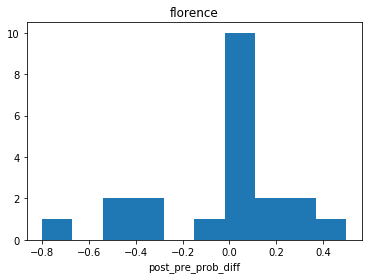

testing data harvey


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
98,0.0,0.500000,0.500000,9,Yubbie007,[Coldplay Concert is still tomorrow in Houston...,[The left is a Houston freeway on Saturday. Th...,harvey
102,0.0,0.444444,0.444444,11,aectgs,[I live in a non-flood area in Houston & moved...,[Now #HurricaneHarvey is projected to head bac...,harvey
136,0.0,0.357143,0.357143,17,theWeatherboy,[If you have travel plans on @United through t...,[If you don't have to travel to/through Housto...,harvey
90,0.0,0.333333,0.333333,5,TwinFountainsTX,[Our Port Lavaca and Rockport clinics will be ...,[These clinics are closed today - Victoria Wal...,harvey
95,0.0,0.333333,0.333333,12,WeHearPodcast,[So. I have a lot of great furniture in storag...,"[First look at Port Aransas, TX. Just happenin...",harvey


array([['Yubbie007',
        list(['Coldplay Concert is still tomorrow in Houston, right? When is #Harvey showing up?', 'Well, get ready for #HurricaneHarvey Texas, especially Houston. A little drizzle turns Houston into an ocean anyways talk of a hurricane.', 'Well, get ready for #HurricaneHarvey Texas, especially Houston. A little drizzle turns Houston into an ocean anyways talk of a hurricane.', 'Well, get ready for #HurricaneHarvey Texas, especially Houston. A little drizzle turns Houston into an ocean anyways talk of a hurricane.', 'Well, get ready for #HurricaneHarvey Texas, especially Houston. A little drizzle turns Houston into an ocean anyways talk of a hurricane.']),
        list(['The left is a Houston freeway on Saturday. The right is the same road on Sunday morning. #Harvey #HurricaneHarvey <URL>', 'The Galleria Mall in Houston, Texas. #HoustonFlood #HurricaneHarvey <URL>'])],
       ['aectgs',
        list(['I live in a non-flood area in Houston & moved here deliberately.

,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
137,0.666667,0.083333,-0.583333,17,thestormreport,"[Port Aransas, TX: A mandatory evacuation ahea...",[Great site to bookmark for Houston area/Harri...,harvey
25,0.600000,0.000000,-0.600000,11,ConleyIsom,[If you need great local weather information f...,[HRRR model shows #Harvey spinning in the same...,harvey
81,0.666667,0.000000,-0.666667,7,ReedTimmerAccu,[I am leaving for Houston immediately to cover...,[TORNADO WARNING just NW of Houston for strong...,harvey
14,1.000000,0.250000,-0.750000,5,CStoreNews_,"[Houston, TX are listening to the weather repo...",[@LAYS #HurricaneHarvey Looks like people in H...,harvey
110,1.000000,0.000000,-1.000000,6,ericfisher,"[By next Wednesday, #Harvey is still expected ...",[Latest #Harvey track...there are FIVE more da...,harvey


array([['thestormreport',
        list(['Port Aransas, TX: A mandatory evacuation ahead of #Harvey . <URL>', 'Brazoria County: Residents living on the Gulf side of Intracoastal Canal under mandatory evacuation ahead of #Harvey <URL>', '#Sunset #PicOfTheDay from Houston, TX! Serene scene before #Harvey begins to move in. #txwx <URL>']),
        list(['Great site to bookmark for Houston area/Harris County rain totals! #Harvey <URL>', '132mph peak wind gust at Port Aransas, TX at landfall last night.  #Harvey <URL>', 'Damage SW of Houston in Sargent, TX. #Harvey #txwx <URL>', 'Buffalo Bayou south of Houston is forecasted to crest at 64 feet, which is ~4 feet higher than previous record #Harvey (forecast: @NWSWGRFC ) <URL>', 'Flooding at KHOU in Houston! #Harvey RT @DougDelonyKHOU : One last look at my desk... #KHOU11 <URL>', 'MT @BrazoriaCounty : Mandatory evacuation for Brazoria County. #Harvey <URL>', 'A flash flood emergency, 4 tornado warnings, and 1 severe thunderstorm warning near t

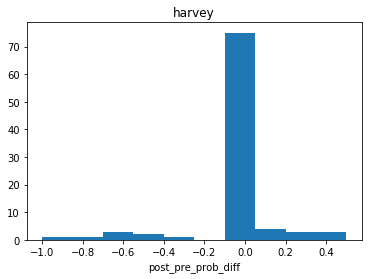

testing data irma


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
90,0.0,1.000000,1.000000,8,DrLindaShelton,[Miami must evacuate #Irma #GOP #p2 #millenial...,[#Irma in Miami flooding #p2 #millenials #vete...,irma
76,0.0,1.000000,1.000000,7,DanEBoy09,[Publix on Jog and Linton in Delray Beach. #Hu...,"[Winds really picking up here in Delray Beach,...",irma
47,0.0,1.000000,1.000000,5,CBS6Leanne,"[Spoke with 2 people heading from Albany, home...",[Family at @AlbanyAirport is glad they changed...,irma
384,0.0,0.666667,0.666667,14,johndissauer,[Latest probability of hurricane force winds f...,[Hurricane #Irma remains a category 4 hurrican...,irma
392,0.0,0.666667,0.666667,5,kasiakovacs,"[""We have to be prepared for it, we have to st...",[A quick traffic and evacuation update for Bea...,irma


array([['DrLindaShelton',
        list(['Miami must evacuate #Irma #GOP #p2 #millenials #veterans #tcot #ccot #BLM #LGBTQ #LatinoAmerica #UniteBlue #Resistance #maga #GenX #DACA <URL>', 'Miami must evacuate #Irma #GOP #p2 #millenials #veterans #tcot #ccot #BLM #LGBTQ #LatinoAmerica #UniteBlue ... <URL>', 'Miami ground zero #Irma #GOP #p2 #millenials #veterans #tcot #ccot #BLM #LGBTQ #LatinoAmerica #UniteBlue #Resistance #maga #GenX <URL>', 'Miami ground zero #Irma #GOP #p2 #millenials #veterans #tcot #ccot #BLM #LGBTQ #LatinoAmerica #UniteBlue ... <URL>', '2 more Hurricanes AFTER #Irma Low lying & Coastal Gulf & E coast must PREPARE NOW -MIAMI & NEARBY EVACUATE NOW= GROUND 0 FOR IRMA <URL>', '2 more Hurricanes AFTER #Irma Low lying & Coastal Gulf & E coast must PREPARE NOW -MIAMI & NEARBY EVACUATE NOW=... <URL>']),
        list(['#Irma in Miami flooding #p2 #millenials #veterans #tcot #ccot #BLM #LGBTQ #LatinoAmerica #UniteBlue #Resistance #maga <URL>', '#Irma in Miami flooding #p2 #mi

,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
92,0.5,0.0,-0.5,5,DrRickKnabb,"[If you’re in Marco Island, Florida you need t...",[Urgent warning about worst storm surge in Nap...,irma
195,0.5,0.0,-0.5,7,MikeTrimWPTV,[Hurricane Watch issued for Palm Beach County....,[***TORNADO WARNING NORTHERN PALM BEACH COUNTY...,irma
436,1.0,0.0,-1.0,5,rjmangus,"[Is Tampa, Florida, Evacuating Because of Hurr...",[Hurricane Irma: Uber is offering free rides t...,irma
121,1.0,0.0,-1.0,5,GregDeeWeather,[Current upper-level NOAA hurricane hunter mis...,[Lakeland could see winds approach 80mph susta...,irma
110,1.0,0.0,-1.0,6,FreedomNetNews,[American Airlines Cancels Miami Flights for H...,[Retweeted Mike Seidel ( @mikeseidel ): Battli...,irma


array([['DrRickKnabb',
        list(['If you’re in Marco Island, Florida you need to evacuate now! See info from @CollierEM . #Irma poses danger of life-threatening storm surge.', 'Mandatory evacuation for Collier County, Fla - the Naples area - for areas west and south of US 41. Evacuate as @CollierEM tells you! #Irma']),
        list(['Urgent warning about worst storm surge in Naples and Marco Island area *after* eye of #Irma passes! <URL>', 'Urgent warning about worst storm surge in Naples and Marco Island area *after* eye of #Irma passes! <URL>', 'Time to stop taking photos of low water in Naples area! Life-threatening opposite coming fast as #Irma eye passes! Get away from the water!'])],
       ['MikeTrimWPTV',
        list(['Hurricane Watch issued for Palm Beach County. #HurricaneIrma #hurricaneirma2017 #Irma <URL>', 'Preparations for #HuricaneIrma happening in West Palm Beach, Florida - businesses on Clematis Street. #irma @wptv <URL>']),
        list(['***TORNADO WARNING NORTH

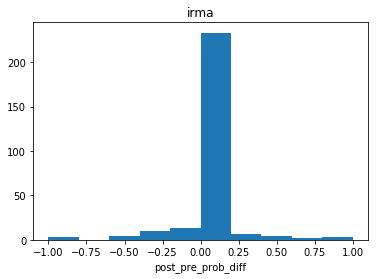

testing data maria


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
11,0.0,0.25,0.25,9,USCGSoutheast,"[#BreakingNews @USCG , @USNavy , @RoyalNavy se...",[The #USCG delievers fuel and water to Vieques...,maria
0,0.0,0.00,0.00,47,BookPuertoRico,"[In San Juan, Partly Cloudy today! With a high...",[In San Juan Cloudy today! With a high of 87F ...,maria
3,0.0,0.00,0.00,7,E_Sqrd_Affair,"[Arecibo #HurricaneMaria #PuertoRico <URL>, Bu...",[AGUA EN BAYAMÓN #PuertoRico #PuertoRicoSeLeva...,maria
8,0.0,0.00,0.00,5,Noti_PuertoRico,[Personas de cualquier pueblo que necesiten no...,[Mañana será el primer día de clases para escu...,maria
9,1.0,1.00,0.00,36,RelaxInPR,"[In San Juan, PR Partly Cloudy today! With a h...","[In San Juan, PR PM Showers today! With a high...",maria


array([['USCGSoutheast',
        list(['#BreakingNews @USCG , @USNavy , @RoyalNavy searching for vessel near Vieques, #PuertoRico after #Hurricane #Maria >> <URL>', '#WATCH @RoyalNavy RFA helicopter crew rescue mom & 2 children near Vieques, P.R. after #HurricaneMaria Full video: <URL>', '. @USCG updates #port conditions for #PuertoRico , #USVI . Fajardo, Culebra, Vieques now open w/ restrictions #Maria <URL>', 'Great picture of @USCG Cutter James serving as command and control platform in San Juan yesterday <URL>', '. @USCG updates #port conditions for #PuertoRico and #USVI : San Juan now open with no restrictions <URL>']),
        list(['The #USCG delievers fuel and water to Vieques, Puerto Rico in response to #HurricaneMaria . <URL>', 'The #USCG delivers 28,000 lbs of supplies in Vieques #PuertoRico for distribution to the victims of #HurricaneMaria . <URL>', '. @USCG Cutter Joseph Tezanos escorts the #USNSComfort into San Juan Tuesday for #HurricaneMaria response efforts. <URL>', '

,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
19,0.000000,0.0,0.000000,12,mog7546,[NEED PLANELOADS San Juan mayor: 'This is a bi...,[San Juan mayor not on Trump's #PuertoRico sch...,maria
20,0.000000,0.0,0.000000,6,noticiapr,[Personas de cualquier pueblo que necesiten no...,[Mañana será el primer día de clases para escu...,maria
23,1.000000,1.0,0.000000,5,torrea40,"[This is a line for gas in San Juan, Puerto Ri...",[The #USCG and partner agencies provide aid to...,maria
2,0.090909,0.0,-0.090909,13,DENISEVASQUEZ,[Worried about my mom! Any news about Cabo Roj...,[There is no aid & no water in Cabo Rojo? Spok...,maria
13,1.000000,0.0,-1.000000,5,femaregion2,"[9/19 — A boarded-up restaurant in San Juan, P...",[#PRStrong —The San Juan @RedCross is among ou...,maria


array([['mog7546',
        list(["NEED PLANELOADS San Juan mayor: 'This is a big S.O.S. for anybody out there' #PuertoRico #Maddow <URL>", "HELP PLZ San Juan mayor: 'This is a big S.O.S. for anybody out there' #PuertoRico #Maddow <URL>", "San Juan mayor criticizes US officials for calling #PuertoRico relief effort 'good news' <URL>"]),
        list(["San Juan mayor not on Trump's #PuertoRico schedule SLIMEBAG PETTY PRESIDENT AVOIDS STRONG WILLED HERO!!! <URL>"])],
       ['noticiapr',
        list(['Personas de cualquier pueblo que necesiten notificar a FEMA los daños sufridos por el #huracánMaría pueden llegar a la alcaldía de Guaynabo <URL>']),
        list(['Mañana será el primer día de clases para escuelas como la Academia San José, en Guaynabo y Saint John’s School, en San Juan. #HuracanMaria <URL>', 'Mañana será el primer día de clases para escuelas como la Academia San José, en Guaynabo y Saint John’s School, en San Juan. #HuracanMaria', 'Además abrirán el Colegio La Milagrosa, 

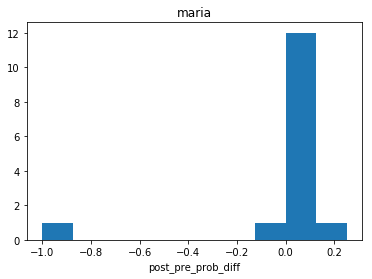

testing data michael


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
15,0.5,1.0,0.5,6,ReedTimmerAccu,[MEXICO BEACH total devastation from big-time ...,"[Mexico Beach, FL storm surge aftermath from h...",michael
18,0.0,0.0,0.0,9,SalArmyFlorida,[The aftermath of #Michael left areas of Flori...,[A team from The #SalvationArmy in Jacksonvill...,michael
30,0.0,0.0,0.0,6,weartv,['Apocalyptic:' Florida's Mexico Beach demolis...,[Mexico Beach took the hardest hit from #Hurri...,michael
29,0.0,0.0,0.0,9,volvoshine,[Just told my aunt (Who lives in Panama city) ...,[My aunt in Panama city was finally able to re...,michael
27,0.0,0.0,0.0,10,kkfla737,[The latest reliable models available (from th...,"[Some remote areas of Jackson, Gulf & Calhoun ...",michael


array([['ReedTimmerAccu',
        list(['MEXICO BEACH total devastation from big-time storm surge and wind with brunt of Hurricane #Michael right eye wall. 24 hours after impact. Very long road of recovery ahead but search and rescue mode continues. Continued coverage for @accuweather <URL>', 'Video: Homes swept of foundation or missing from their stilt foundation in Mexico Beach, FL; scenes of complete destruction up and down the beach. This was where the brunt of Hurricane #Michael storm surge came ashore @breakingweather @accuweather <URL>']),
        list(["Mexico Beach, FL storm surge aftermath from helicopter 48 hours after Hurricane #Michael landfall. This is why you don't stay near the beach when a category 4 hurricane is coming ashore. @accuweather <URL>"])],
       ['SalArmyFlorida',
        list(['The aftermath of #Michael left areas of Florida unrecognizable from the peaceful beach towns they were just a few days ago. The #SalvationArmy has 43 mobile feeding kitchens commit

,pre_prob,post_prob,post_pre_prob_diff,NE_count,username,pre_peak_txt,post_peak_txt,data_name
7,0.2,0.0,-0.2,12,FLHSMV,[As parts of Florida continue to recover from ...,[FLOW Mobiles have been deployed to assist res...,michael
24,1.0,0.5,-0.5,10,amlikethewind,[Wind and waves starting to pick up #hurricane...,[Officials ZooWorld in Panama City Beach tell ...,michael
32,1.0,0.5,-0.5,6,wxkaylee13,[#HurricaneMichael made landfall at 12:30pm CT...,[Oh wow! A water tower was taken down in Mexic...,michael
3,1.0,0.0,-1.0,5,CharlesPDavis,"[Damage from #HurricaneMichael in Panama City,...",[#Repost @abc ・・・ A gas station in Panama City...,michael
14,1.0,0.0,-1.0,9,ReadCarlos,[Prayers for those in harms way as Category 4 ...,[Covering #HurricaneMichael ... please contact...,michael


array([['FLHSMV',
        list(['As parts of Florida continue to recover from #HurricaneMichael , @FLHSMV offices will be closed on Friday, October 12th in the following counties: Bay, Calhoun, Franklin, Gadsden, Gulf, Hamilton, Jackson, Jefferson, Leon, Liberty, Madison, Suwannee, Taylor, and Wakulla.', 'As parts of Florida continue to recover from #HurricaneMichael , @FLHSMV offices will be closed on Friday, October 12th in the following counties: Bay, Calhoun, Franklin, Gadsden, Gulf, Hamilton, Jackson, Jefferson, Leon, Liberty, Madison, Suwannee, Taylor, and Wakulla.', 'As parts of Florida continue to recover from #HurricaneMichael , @FLHSMV offices will be closed on Friday, October 12th in the following counties: Bay, Calhoun, Franklin, Gadsden, Gulf, Hamilton, Jackson, Jefferson, Leon, Liberty, Madison, Suwannee, Taylor, and Wakulla.', 'As parts of Florida continue to recover from #HurricaneMichael , @FLHSMV offices will be closed on Friday, October 12th in the following counties

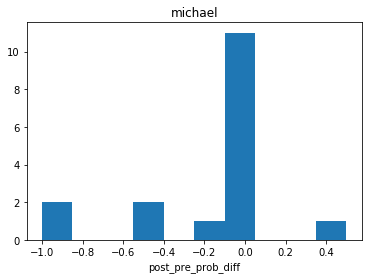

In [126]:
top_k = 5
for name_i, data_i in author_anchor_data.groupby('data_name'):
    print('testing data %s'%(name_i))
    data_i.sort_values('post_pre_prob_diff', inplace=True, ascending=False)
    display(data_i.head(top_k))
    display(data_i.head(top_k).loc[:, ['username', 'pre_peak_txt', 'post_peak_txt']].values)
    display(data_i.tail(top_k))
    display(data_i.tail(top_k).loc[:, ['username', 'pre_peak_txt', 'post_peak_txt']].values)
    # also plot distribution of probability difference
    plt.hist(data_i.loc[:, 'post_pre_prob_diff'], bins=10)
    plt.xlabel('post_pre_prob_diff')
    plt.title(name_i)
    plt.show()

Similar story:

- increase authors: locals trying to reach bigger audience, share info from more far-reaching news media, providing more specific information (concrete?)

data|author|pre|post
---|---|---|---
harvey|aectgs|I live in a non-flood area in Houston|I live in Houston ,Texas and I truly appreciate your support!
irma|johndissauer|60% prob by 5pm Sunday in Miami. 40% prob by 6pm Sun in Naples|Naples, Florida is now about 45-miles from the center
- decrease authors: following news media, assume audience has prior knowledge of NE; addressing new information need with old information

data|author|pre|post
---|---|---|---
florence|bergerchris|So thankful for dedicated Nurses who answered the call to help the #Florence impacted Wilmington, NC area|So proud of these @AtriumHealth medical professionals who just returned to Charlotte from Wilmington
irma|rjmangus|Is Tampa, Florida, Evacuating Because of Hurricane Irma?|Uber is offering free rides to Tampa shelters, but only for a while

As we saw before, there aren't many examples of consistent author-NE pairs to compare/analyze.